# Master Sentiment Index: Loughran & McDonald | TextBlob | Alchemy API

__Author__: Jannick Sicher

This notebook features three out of the four approaches used to build the sentiment index. However, this code does not include the main sentiment index, which was created with the SentiWS Dictionary, as it has been especially isolated as it is the most relevant part of the bachelor thesis. That is, the following notebooks are combined here: Loughran & McDonald index, TextBlob index, and Alchemy API index. These are presented separately, but condensed here.

## Initial Configurations and Packages

In [1]:
%matplotlib inline
import sys
import os
import pandas as pd
import json
from watson_developer_cloud import DiscoveryV1
import requests
from nytimesarticle import articleAPI
import time
import nltk
from bs4 import BeautifulSoup as soup
import bs4 as bs
import requests
import re
import quandl
from textblob import TextBlob
from nltk import word_tokenize
from nltk import tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk import FreqDist
from bs4 import BeautifulSoup
import matplotlib
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from textblob_de import TextBlobDE
from urllib.request import urlopen as uReq
from sklearn.preprocessing import StandardScaler
import datetime
import backtrader as bt
import backtrader.feeds as btfeed
import backtrader.indicators as btind
plt.style.use('ggplot')


### Initial configuration for the IBM Discovery News API ###
discovery = DiscoveryV1(
    version='2018-05-03',
    username='522af75a-3b5f-4300-96c1-10035cb0e22f',
    password='8gxPSA0bJizc')

### Quandl Authentification
quandl.ApiConfig.api_key = "4e_fG9_V8Xur9cnx9-Ys"

## Query Function for Alchemy API: News Articles

This section provides a query function to call the latest news articles for a company. Just uncomment the following code and change the _"CompanyName"_ with the desired company of your choice. By default, the search query provides only English news articles to simplify the sentiment analysis. However, if you want to receive German news articles, you can change language to _"de"_. 

In [2]:
## Query function to search articles for companies
qopts = {'query': 'enriched_text.entities.text:UBS', 'language':'en', 'title': 'UBS'}
UBS = discovery.query('system', 'news-en', qopts)
print(json.dumps(UBS, indent=2))

{
  "matching_results": 108823,
  "results": [
    {
      "id": "Nkr_HB6-se5NY6a4S88gn0xBpaRCUjQ3e9qR6qYC6pLdUyUvOwQJ_1P4hr5LOsfM",
      "result_metadata": {
        "score": 0
      },
      "enriched_title": {
        "entities": [],
        "sentiment": {
          "document": {
            "score": 0,
            "label": "neutral"
          }
        },
        "semantic_roles": [],
        "concepts": [
          {
            "text": "Marketing",
            "relevance": 0.897579,
            "dbpedia_resource": "http://dbpedia.org/resource/Marketing"
          },
          {
            "text": "Capitalism",
            "relevance": 0.841148,
            "dbpedia_resource": "http://dbpedia.org/resource/Capitalism"
          },
          {
            "text": "Stock market",
            "relevance": 0.784883,
            "dbpedia_resource": "http://dbpedia.org/resource/Stock_market"
          }
        ],
        "categories": [
          {
            "score": 0.128884,
     

## Data Preparation

In the first step of this notebook, I prepare the data for each company. Firstly, I created a JSON file using approximately 500 news articles (the most relevant in the Watson News Discovery database) for each company during the last two months. The JSON file provides all needed information such as the source, URL, text, author, language, etc. In this section, I loaded all JSON files and transformed them into a Pandas dataframe using the Pandas package. After doing that, I saved the csv file for each company. 

### JSON file for UBS

In [3]:
# Load json file of UBS articles
with open('UBS_dataset_new.json') as json_data:
    UBS_json = json.load(json_data)

# Transform 'results' of json file into pandas dataframe
UBS_df = pd.DataFrame(UBS_json['results'])

# Transform date into datetime
UBS_df['datetime'] = pd.to_datetime(UBS_df['publication_date'])

# Save created pandas df to csv
UBS_df.to_csv('UBS_df.csv')

### JSON file for Nestlé

In [4]:
# Load json file of Nestlé articles
with open('Nestle_dataset_new.json') as json_data:
    Nestle_json = json.load(json_data)

# Transform 'results' of json file into pandas dataframe
Nestle_df = pd.DataFrame(Nestle_json['results'])

# Transform date into datetime
Nestle_df['datetime'] = pd.to_datetime(Nestle_df['publication_date'])

# Save created pandas df to csv
Nestle_df.to_csv('Nestle_df.csv')

### JSON file for Roche

In [5]:
# Load json file of Roche articles
with open('Roche_dataset_new.json') as json_data:
    Roche_json = json.load(json_data)

# Transform results json file into pandas dataframe
Roche_df = pd.DataFrame(Roche_json['results'])

# Transform date into datetime
Roche_df['datetime'] = pd.to_datetime(Roche_df['publication_date'])

# Save created pandas df to csv
Roche_df.to_csv('Roche_df.csv')

### JSON file for Novartis

In [6]:
# Load json file of Novartis articles
with open('Novartis_dataset_new.json') as json_data:
    Novartis_json = json.load(json_data)  

# Transform results json file into pandas dataframe
Novartis_df = pd.DataFrame(Novartis_json['results'])    

# Transform date into datetime
Novartis_df['datetime'] = pd.to_datetime(Novartis_df['publication_date'])

# Save created pandas df to csv
Novartis_df.to_csv('Novartis_df.csv') 

### JSON file for ABB

In [7]:
# Load json file of ABB articles
with open('ABB_dataset_new.json') as json_data:
    ABB_json = json.load(json_data)

# Transform results json file into pandas dataframe
ABB_df = pd.DataFrame(ABB_json['results'])  

# Transform date into datetime
ABB_df['datetime'] = pd.to_datetime(ABB_df['publication_date'])

# Save created pandas df to csv
ABB_df.to_csv('ABB_df.csv')

## Sentiment Analysis with Loughran and McDonald Dictionary
In this section, I will present a method of sentiment analysis using a financial dictionary. More precisely, I will use the Loughrand and McDonald Dictionary, which was initially developed in a paper published in the Journal of Finance (“When is a Liability not a Liability?, 2011). The financial dictionary consists of four different sentiments (positive, negative, litigious, uncertain). To develop a sentiment score, I will primarily make use of the positive and negative dictionary to create a simple sentiment score for each news article. 

### Sample Article of UBS
This section provides a sample article and a basic URL of the UBS Group. As you can see here, the parser function of the Alchemy API is unfortunately not able to parse the whole text of the article and is only able to parse a certain amount (including the headline). This is due to the fact that the Alchemy API scrapes a large number of web pages that cannot entirely be captured in the corresponding HTML of the specific website.

In [8]:
# Display article sample text for an article
UBS_df['text'][0]

'UBS publishes Annual Report 2017 Latest media releases UBS publishes Annual Report 2017 Zurich 09 Mar 2018, 06:45 Price Sensitive Information UBS’s Annual Report 2017 and Compensation Report available at www.ubs.com/annualreporting Zurich/Basel, 9 March 2018 – The Annual Report 2017 provides comprehensive and detailed information on the firm, its strategy, business, governance, financial performance and risk, treasury and capital management, as well as on the regulatory and operating environment for the financial year 2017. UBS net profit attributable to shareholders for 2017 was CHF 1.1 billion and diluted earnings per share were CHF 0.27. The 2017 results and the balance sheet as of 31 December 2017 differ from those presented in the unaudited fourth quarter 2017 report published on 22 January 2018 as a result of adjusting events after the reporting period. Provisions for litigation, regulatory and similar matters increased, which reduced 2017 operating profit before tax by CHF 141'

In [9]:
# Show web_url for comparison reasons
UBS_df['url'][0]

'http://www.six-swiss-exchange.com/issuers/services/tensid_news_en.html?id=f72c1eb2'

### Tokenize Function: Word Conversion, Stop Words Removal, Tokenization
This function provides three functionalities: Firstly, each text is converted into lower case for simplifying the sentiment analysis. Subsequently, all stop words are removed (stop words are words that are repetitive, like the word "the" and are not necessary to define the sentiment of an article). Finally, the words of each text are tokenized, meaning that each word is segmentized to its root form). After tokenization, each word less than three letters is removed since they are not needed for the further sentiment analysis. 

In [10]:
# Tokenize and stop words removal
def tokenize(text):

    # Convert to lower case
    words = map(lambda word: word.lower(), word_tokenize(text))
    
    # Remove stop words
    cachedStopWords = stopwords.words("english")
    words = [word for word in words
                  if word not in cachedStopWords]
    
    # Steam the words
    tokens =(list(map(lambda token: PorterStemmer().stem(token), words)))
    
    # Remove non-letters 
    p = re.compile('[a-zA-Z]+')
    
    # Remove less than 3 length words
    min_length = 3
    filtered_tokens = list(filter(lambda token: p.match(token) and len(token) >= min_length, tokens))
    
    return filtered_tokens

In [11]:
# Apply tokenizer to UBS
UBS_df['tokens'] = UBS_df['text'].apply(tokenize)

# Apply tokenizer to Nestle
Nestle_df['tokens'] = Nestle_df['text'].apply(tokenize)

# Apply tokenizer to Roche
Roche_df['tokens'] = Roche_df['text'].apply(tokenize)

# Apply tokenizer to Novartis
Novartis_df['tokens'] = Novartis_df['text'].apply(tokenize)

# Apply tokenizer to ABB
ABB_df['tokens'] = ABB_df['text'].apply(tokenize)

In [12]:
# Display first tokenized article for UBS for review
UBS_df['tokens'][0]

['publish',
 'annual',
 'report',
 'latest',
 'media',
 'releas',
 'publish',
 'annual',
 'report',
 'zurich',
 'mar',
 'price',
 'sensit',
 'inform',
 'annual',
 'report',
 'compens',
 'report',
 'avail',
 'www.ubs.com/annualreport',
 'zurich/basel',
 'march',
 'annual',
 'report',
 'provid',
 'comprehens',
 'detail',
 'inform',
 'firm',
 'strategi',
 'busi',
 'govern',
 'financi',
 'perform',
 'risk',
 'treasuri',
 'capit',
 'manag',
 'well',
 'regulatori',
 'oper',
 'environ',
 'financi',
 'year',
 'net',
 'profit',
 'attribut',
 'sharehold',
 'chf',
 'billion',
 'dilut',
 'earn',
 'per',
 'share',
 'chf',
 'result',
 'balanc',
 'sheet',
 'decemb',
 'differ',
 'present',
 'unaudit',
 'fourth',
 'quarter',
 'report',
 'publish',
 'januari',
 'result',
 'adjust',
 'event',
 'report',
 'period',
 'provis',
 'litig',
 'regulatori',
 'similar',
 'matter',
 'increas',
 'reduc',
 'oper',
 'profit',
 'tax',
 'chf']

### Text Mining Function: Loughran and McDonald Dictionary
Each dictionary provided by Loughran and McDonal are now loaded and will be used to determine the sentiment of each news article.

In [13]:
# Loading the financial dictionary provided by Loughran and McDonald
with open('LoughranMcDonald_Positive.csv', 'r') as f: 
    pos = ''
    for row in f:
        pos += row.replace('\n',',')
with open('LoughranMcDonald_Negative.csv', 'r') as f: 
    neg = ''
    for row in f:
        neg += row.replace('\n',',')
with open('LoughranMcDonald_Litigious.csv', 'r') as f: 
    lit = ''
    for row in f:
        lit += row.replace('\n',',')
with open('LoughranMcDonald_Uncertainty.csv', 'r') as f: 
    unc = ''
    for row in f:
        unc += row.replace('\n',',')

### UBS: Apply Text Mining Function
In this section, I will apply a text mining function that counts the occurences of positive, negative, litigious and uncertain words of each article according to the Loughran and McDonald financial dictionary. Bear in mind that this process is rather time consuming because of approximately 2500 news articles. This text mining function is applied to every company and saved to the pandas dataframe.

In [14]:
# Text mine function for UBS
def text_mine_articles(UBS_df, bag_of_words,alignment):
    
    bag_of_words = tokenize(bag_of_words)
    UBS_df['num_occurr_'+alignment] = 0
    
    # 'Set' to make the counting operation faster
    set_of_words = set(bag_of_words)
    
    print('Text mine articles...'),
    
    for j in range(0, len(UBS_df)):
        
        # Convert article body into a list of tokens
        tokenized_article = tokenize(UBS_df['text'][j])
        
        # Count occurrences of the dictionary of words
        occurrences = [word for word in tokenized_article
                        if word in set_of_words]
        
        # Copy amount of occurrences found to the dataframe
        amount = len(occurrences)
        UBS_df['num_occurr_'+alignment][j] = amount
        
    # Compute frequency of occurrence found in each article dividing
    # the amount of words counted as occurrences by the amount of words in the article
    # UBS_df['freq_occurr_'+alignment] = UBS_df['num_occurr_'+alignment]/UBS_df['word_count']   
   
    print('Done!')
 
    return UBS_df

In [15]:
# Text mine all articles for each sentiment (positive, negative, litigious, uncertain)
UBS_df = text_mine_articles(UBS_df, pos,'pos')
UBS_df = text_mine_articles(UBS_df, neg,'neg')
UBS_df = text_mine_articles(UBS_df, lit,'lit')
UBS_df = text_mine_articles(UBS_df, unc,'unc')

Text mine articles...


/Users/Jannick/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Done!
Text mine articles...
Done!
Text mine articles...
Done!
Text mine articles...
Done!


### Sentiment Score
This section provides a simple calculation for the sentiment score. The sentiment score consists of the difference between the number of positive words and negative words according to the Loughran and McDonald dictionary. After creating each sentiment score for every article, I compute the average for any given day. This will further help me to set up my trading strategy. 

In [16]:
## Sentiment Score UBS
# The following function provides a simple function to create a sentiment score
UBS_df['sentiment_score'] = UBS_df['num_occurr_pos'] - UBS_df['num_occurr_neg']

#### Daily Average Score

In [17]:
UBS_avg_df = pd.read_excel('Sentiment_Score_UBS.xlsx')
UBS_avg_df.head()

,datetime,sentiment_score,watson_sentiment_score,polarity,subjectivity
0,2018-03-03 00:00:00,2,-0.411911,0.248295,0.573485
1,2018-03-03 00:00:00,2,NaN,0.248295,0.573485
2,2018-03-04 07:16:00,1,0.181441,0.138695,0.282556
3,2018-03-04 07:16:00,1,NaN,0.099107,0.326687
4,2018-03-04 10:58:00,-1,NaN,-0.065476,0.372619


In [18]:
# Create .dt.date format
UBS_avg_df['date'] = UBS_avg_df['datetime'].dt.date

In [19]:
# Creates a function that computes the mean value for each day 
unique_dates = UBS_avg_df['date'].unique()
UBS_means_df = pd.DataFrame()

for date in unique_dates:
    same_date = UBS_avg_df.loc[UBS_avg_df['date'] == date]
    
    sentiment_mean = same_date['sentiment_score'].mean()
    watson_mean = same_date['watson_sentiment_score'].mean()
    polarity_mean = same_date['polarity'].mean()

    UBS_means_df = UBS_means_df.append({'date': date, 'sentiment': sentiment_mean, 'watson': watson_mean, 
                                        'polarity': polarity_mean}, ignore_index=True)


In [20]:
UBS_means_df.head()

,date,polarity,sentiment,watson
0,2018-03-03,0.248295,2.000000,-0.411911
1,2018-03-04,0.054634,-1.000000,0.190002
2,2018-03-05,0.025303,0.428571,0.308881
3,2018-03-06,0.058877,0.666667,0.163440
4,2018-03-07,0.008555,-1.666667,0.220010


In [21]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('UBS_means_df.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
UBS_means_df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [22]:
# Open adjusted UBS file containing all sentiment scores 
UBS_means_adjusted_df = pd.read_excel('UBS_means_adjusted_df.xlsx')

# Transform date to datetime format
UBS_means_adjusted_df['datetime'] = pd.to_datetime(UBS_means_adjusted_df['date'])

# Display head of newly created dataframe
UBS_means_adjusted_df.head()

,date,polarity,sentiment,watson,datetime
0,2018-03-03,0.248295,2.000000,-0.411911,2018-03-03
1,2018-03-04,0.054634,-1.000000,0.190002,2018-03-04
2,2018-03-05,0.025303,0.428571,0.308881,2018-03-05
3,2018-03-06,0.058877,0.666667,0.163440,2018-03-06
4,2018-03-07,0.008555,-1.666667,0.220010,2018-03-07


#### Plot for daily average score 

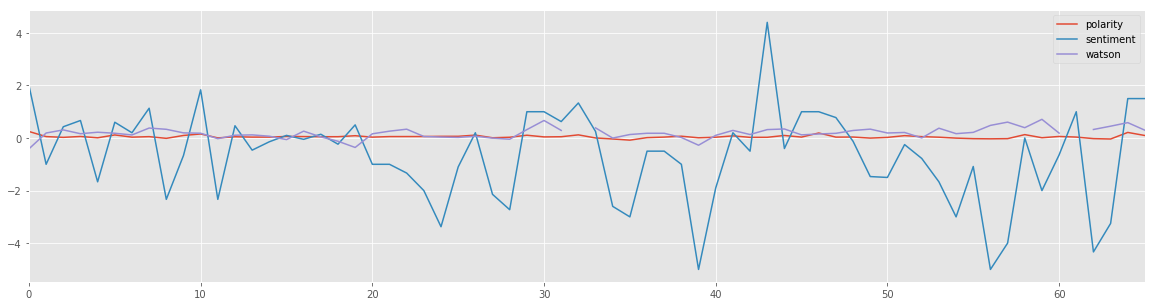

In [23]:
UBS_means_adjusted_df.plot(legend = True, label = 'Daily Sentiment Score', 
                                    figsize = (20, 5))

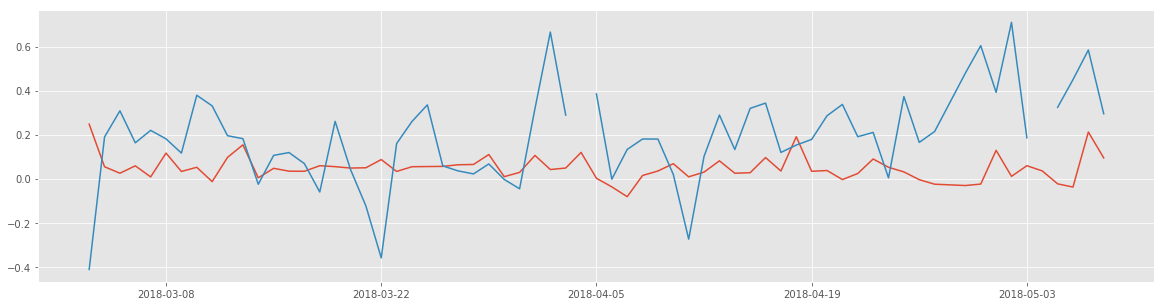

In [24]:
# Plot for Watson Sentiment and Polarity
plt.figure(figsize=(20,5))
plt.plot(UBS_means_adjusted_df['datetime'],UBS_means_adjusted_df['polarity'])
plt.plot(UBS_means_adjusted_df['datetime'],UBS_means_adjusted_df['watson'])
plt.show()

#### Create Excel File

In [25]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('UBS_df.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
UBS_df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

/Users/Jannick/anaconda3/lib/python3.6/site-packages/xlsxwriter/worksheet.py:830: UserWarning: Ignoring URL 'https://i.guim.co.uk/img/media/a0513d544ecb7ac1219f26cd76c513ebe40c7788/0_57_4096_2457/4096.jpg?w=1200&amp;h=630&amp;q=55&amp;auto=format&amp;usm=12&amp;fit=crop&amp;crop=faces%2Centropy&amp;bm=normal&amp;ba=bottom%2Cleft&amp;blend64=aHR0cHM6Ly91cGxvYWRzLmd1aW0uY28udWsvMjAxOC8wMS8zMS9mYWNlYm9va19kZWZhdWx0LnBuZw&amp;s=15975c6a4df1ef60177b9e899855e082' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))


In [26]:
UBS_df.head()

,author,country,crawl_date,enriched_text,enriched_title,external_links,extracted_metadata,forum_title,highlight,host,...,text,title,url,datetime,tokens,num_occurr_pos,num_occurr_neg,num_occurr_lit,num_occurr_unc,sentiment_score
0,NaN,CH,2018-03-09T08:21:34Z,"{'entities': [{'count': 10, 'sentiment': {'sco...","{'entities': [{'count': 1, 'sentiment': {'scor...",NaN,{'sha1': '383c3c4c371211a450fb15a5a547c967a702...,SIX Swiss Exchange | Equity issuer newsfeed,{'enriched_text.semantic_roles.object.entities...,six-swiss-exchange.com,...,UBS publishes Annual Report 2017 Latest media ...,UBS Group AG,http://www.six-swiss-exchange.com/issuers/serv...,2018-03-09 00:00:00,"[publish, annual, report, latest, media, relea...",4,1,3,2,3
1,AP연합뉴스 | 네이버 뉴스,KR,2018-05-03T09:55:57Z,"{'entities': [{'count': 2, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...","[http://www.hellophoto.kr/?did=1195s, https://...",{'sha1': '1e59d0bd5c545cede135fcdb1bf20d1beb3d...,NaN,{'enriched_text.semantic_roles.object.entities...,news.naver.com,...,"Axel A. Weber, Chairman of the Board of Direct...",Switzerland UBS,http://news.naver.com/main/read.nhn?oid=077&ai...,2018-05-03 09:48:00,"[axel, weber, chairman, board, director, swiss...",0,0,0,1,0
2,From cnbc.com,US,2018-04-16T11:13:10Z,"{'entities': [{'count': 1, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...",NaN,{'sha1': '6288a551e9ff88927f298712297ecc64bb3e...,FF All News,{'enriched_text.semantic_roles.object.entities...,forexfactory.com,...,From cnbc.com The super wealthy want more out ...,The ultra-rich want to make money through good...,https://www.forexfactory.com/news.php?do=news&...,2018-04-16 10:35:00,"[cnbc.com, super, wealthi, want, invest, day, ...",3,2,0,0,1
3,Yen Nee Lee,US,2018-04-16T01:23:30Z,"{'entities': [{'count': 1, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...",NaN,{'sha1': '4d5fea48b773dd3534a442c024fd8c192b09...,World News &amp;amp; Analysis,{'enriched_text.semantic_roles.object.entities...,cnbc.com,...,The super wealthy want more out of their inves...,UBS: Ultra-high net worth investors find susta...,https://www.cnbc.com/2018/04/15/ubs-ultra-high...,2018-04-16 02:21:00,"[super, wealthi, want, invest, day, addit, fin...",2,1,0,0,1
4,EPA연합뉴스 | 네이버 뉴스,KR,2018-05-03T11:33:08Z,"{'entities': [{'count': 1, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...","[http://www.hellophoto.kr/?did=1195s, https://...",{'sha1': 'ad83676b0e7dd231b26b25a5ce1cfb7b5039...,NaN,{'enriched_text.relations.arguments.entities.t...,news.naver.com,...,"UBS general assembly Sergio P. Ermotti, Group ...",SWITZERLAND UBS GENERAL ASSEMBLY,http://news.naver.com/main/read.nhn?oid=091&ai...,2018-05-03 09:44:00,"[gener, assembl, sergio, ermotti, group, chief...",0,1,0,1,-1


### Nestle: Apply Text Mining Function

In [27]:
# Text mine function for Nestle
def text_mine_articles(Nestle_df, bag_of_words,alignment):
    
    bag_of_words = tokenize(bag_of_words)
    Nestle_df['num_occurr_'+alignment] = 0
    
    # 'Set' to make the counting operation faster
    set_of_words = set(bag_of_words)
    
    print('Text mine articles...'),
    
    for j in range(0, len(Nestle_df)):
        
        # Convert article body into a list of tokens
        tokenized_article = tokenize(Nestle_df['text'][j])
        
        # Count occurrences of the dictionary of words
        occurrences = [word for word in tokenized_article
                        if word in set_of_words]
        
        # Copy amount of occurrences found to the dataframe
        amount = len(occurrences)
        Nestle_df['num_occurr_'+alignment][j] = amount
        
    # Compute frequency of occurrence found in each article dividing
    # the amount of words counted as occurrences by the amount of words in the article
    # UBS_df['freq_occurr_'+alignment] = UBS_df['num_occurr_'+alignment]/UBS_df['word_count']   
   
    print('Done!')
 
    return Nestle_df

In [28]:
# Text mine all articles for each sentiment (positive, negative, litigious, uncertain)
Nestle_df = text_mine_articles(Nestle_df, pos,'pos')
Nestle_df = text_mine_articles(Nestle_df, neg,'neg')
Nestle_df = text_mine_articles(Nestle_df, lit,'lit')
Nestle_df = text_mine_articles(Nestle_df, unc,'unc')

Text mine articles...


/Users/Jannick/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Done!
Text mine articles...
Done!
Text mine articles...
Done!
Text mine articles...
Done!


### Sentiment Score

In [29]:
## Sentiment Score Nestle
# The following function provides a simple function to create a sentiment score
Nestle_df['sentiment_score'] = Nestle_df['num_occurr_pos'] - Nestle_df['num_occurr_neg']

#### Daily Average Score

In [30]:
Nestle_avg_df = pd.read_excel('Sentiment_Score_Nestle.xlsx')
Nestle_avg_df.head()

,publication_date,sentiment_score,watson_sentiment_score,polarity,subjectivity
0,2018-03-04,0,0.337530,-0.031250,0.193750
1,2018-03-06,-2,0.326074,-0.054167,0.270833
2,2018-03-07,0,0.234258,-0.065000,0.285000
3,2018-03-07,0,0.234258,-0.065000,0.285000
4,2018-03-07,2,0.112489,0.049333,0.354000


In [31]:
# Transform date into datetime
Nestle_avg_df['datetime'] = pd.to_datetime(Nestle_avg_df['publication_date'])

In [32]:
# Create .dt.date format
Nestle_avg_df['date'] = Nestle_avg_df['publication_date'].dt.date

In [33]:
# Creates a function that computes the mean value for each day 
unique_dates = Nestle_avg_df['date'].unique()
Nestle_means_df = pd.DataFrame()

for date in unique_dates:
    same_date = Nestle_avg_df.loc[Nestle_avg_df['date'] == date]
    
    sentiment_mean = same_date['sentiment_score'].mean()
    watson_mean = same_date['watson_sentiment_score'].mean()
    polarity_mean = same_date['polarity'].mean()

    Nestle_means_df = Nestle_means_df.append({'sentiment': sentiment_mean, 'watson': watson_mean, 
                                        'polarity': polarity_mean}, ignore_index=True)

In [34]:
Nestle_means_df.head()

,polarity,sentiment,watson
0,-0.031250,0.000000,0.337530
1,-0.054167,-2.000000,0.326074
2,0.083334,0.428571,0.422974
3,0.039583,1.250000,0.552919
4,0.034476,-2.000000,0.410237


In [35]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('Nestle_means_df.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
Nestle_means_df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [36]:
# Open adjusted UBS file containing all sentiment scores 
Nestle_means_adjusted_df = pd.read_excel('Nestle_means_adjusted_df.xlsx')

# Transform date to datetime format
Nestle_means_adjusted_df['datetime'] = pd.to_datetime(Nestle_means_adjusted_df['date'])

# Display head of newly created dataframe
Nestle_means_adjusted_df.head()

,date,polarity,sentiment,watson,datetime
0,2018-03-03,-0.042708,-1.000000,0.331802,2018-03-03
1,2018-03-04,0.064522,0.583333,0.479074,2018-03-04
2,2018-03-05,0.056555,0.142857,0.379411,2018-03-05
3,2018-03-06,0.129104,0.888889,0.317479,2018-03-06
4,2018-03-07,0.080297,0.888889,0.322605,2018-03-07


#### Plot for daily average score

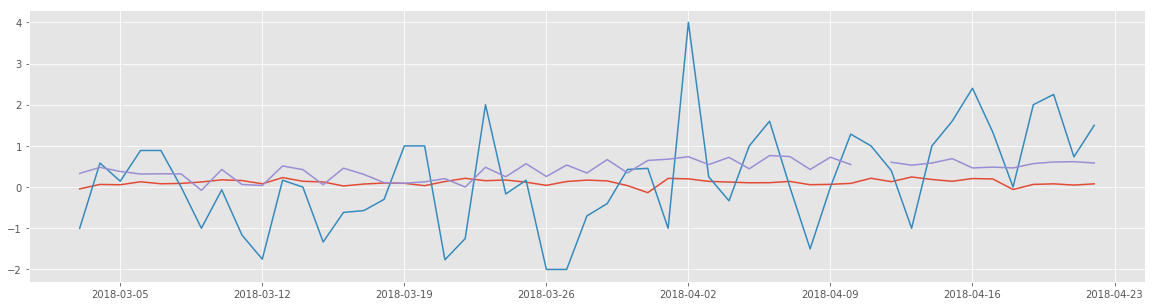

In [37]:
plt.figure(figsize=(20,5))
plt.plot(Nestle_means_adjusted_df['datetime'],Nestle_means_adjusted_df['polarity'])
plt.plot(Nestle_means_adjusted_df['datetime'],Nestle_means_adjusted_df['sentiment'])
plt.plot(Nestle_means_adjusted_df['datetime'],Nestle_means_adjusted_df['watson'])
plt.show()
#Nestle_means_adjusted_df.plot(legend = True, label = 'Daily Sentiment Score',figsize = (20, 5))

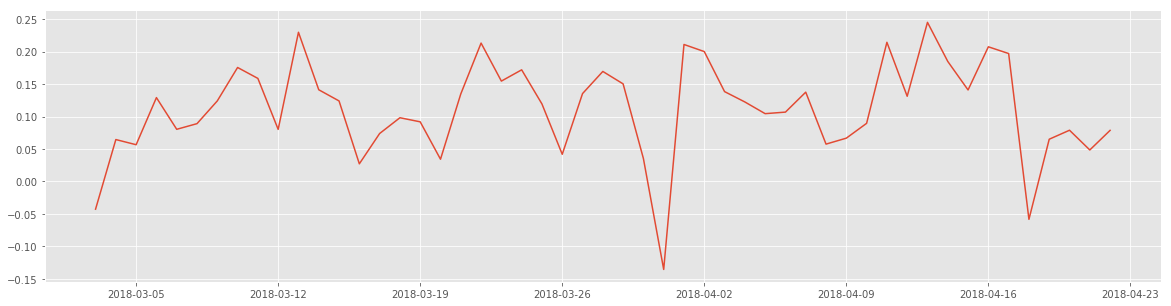

In [38]:
# Plot for Watson Sentiment and Polarity
plt.figure(figsize=(20,5))
plt.plot(Nestle_means_adjusted_df['datetime'],Nestle_means_adjusted_df['polarity'])
# plt.plot(Nestle_means_adjusted_df['datetime'],Nestle_means_adjusted_df['watson'])
plt.show()

#### Create Excel File

In [39]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('Nestle_df.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
Nestle_df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

/Users/Jannick/anaconda3/lib/python3.6/site-packages/xlsxwriter/worksheet.py:830: UserWarning: Ignoring URL 'https://www.thehindubusinessline.com/migration_catalog/article18318387.ece/ALTERNATES/LANDSCAPE_615/The%20Nestle%20logo%20is%20pictured%20on%20the%20company%20headquarters%20entrance%20building%20in%20Vevey%20Switzerland%20February%2018%202016%20REUTERSPierre%20AlbouyFile%20Photo' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))
/Users/Jannick/anaconda3/lib/python3.6/site-packages/xlsxwriter/worksheet.py:830: UserWarning: Ignoring URL 'https://i.guim.co.uk/img/media/41a7fa38071bce7635b8a540ee230fec48ebe92c/85_2_1838_1103/master/1838.jpg?w=1200&amp;h=630&amp;q=55&amp;auto=format&amp;usm=12&amp;fit=crop&amp;crop=faces%2Centropy&amp;bm=normal&amp;ba=bottom%2Cleft&amp;blend64=aHR0cHM6Ly91cGxvYWRzLmd1aW0uY28udWsvMjAxOC8wMS8zMS9mYWNlYm9va19kZWZhdWx0LnBuZw&amp;s=4f38784467b55888f82e01025916c162' with link or location/anchor > 2

In [40]:
Nestle_df.head()

,author,country,crawl_date,enriched_text,enriched_title,external_links,extracted_metadata,forum_title,highlight,host,...,text,title,url,datetime,tokens,num_occurr_pos,num_occurr_neg,num_occurr_lit,num_occurr_unc,sentiment_score
0,EPA연합뉴스 | 네이버 뉴스,KR,2018-04-12T15:45:52Z,"{'entities': [{'count': 2, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...","[http://www.hellophoto.kr/?did=1195s, https://...",{'sha1': '39e1180c6da58c5c00e2bd49cf5f41f8dcb9...,NaN,{'enriched_text.semantic_roles.object.text': [...,news.naver.com,...,Nestle annual general meeting in Lausanne A Ne...,SWITZERLAND NESTLE ANNUAL GENERAL MEETING,http://news.naver.com/main/read.nhn?oid=091&ai...,2018-04-12 13:54:00,"[nestl, annual, gener, meet, lausann, nestl, l...",0,0,0,0,0
1,EPA연합뉴스 | 네이버 뉴스,KR,2018-04-18T13:27:01Z,"{'entities': [{'count': 3, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...","[http://www.hellophoto.kr/?did=1195s, https://...",{'sha1': '47edd4829253b226a92bc85f1e16afbc1f3a...,NaN,{'enriched_text.semantic_roles.object.text': [...,news.naver.com,...,Nestle results (FILE) - A file picture dated 0...,(FILE) SWITZERLAND ECONOMY NESTLE 뉴스,http://news.naver.com/main/read.nhn?oid=091&ai...,2018-04-18 13:09:00,"[nestl, result, file, file, pictur, date, apri...",0,0,0,0,0
2,NaN,FR,2018-04-25T00:37:16Z,"{'entities': [{'count': 2, 'sentiment': {'scor...","{'entities': [], 'sentiment': {'document': {'s...",NaN,{'sha1': '3f4ad04a276645e05ba83f14eaca15a1e3a2...,Nigeria News (News Reader) |,{'enriched_text.semantic_roles.object.text': [...,nigeria.shafaqna.com,...,7 hours ago Nestle tops gainers’ chart at NSE ...,Nestle tops gainers’ chart at NSE,http://nigeria.shafaqna.com/EN/NG/5309082,2018-04-24 17:27:00,"[hour, ago, nestl, top, gainer, chart, nse, pr...",0,1,0,1,-1
3,in_admin,IN,2018-05-04T12:49:27Z,"{'entities': [{'count': 3, 'sentiment': {'scor...","{'entities': [], 'sentiment': {'document': {'s...",NaN,{'sha1': '74c17e617afaf7b34b6b9a5e88699e2d174e...,IBNMoney India In,{'enriched_text.relations.arguments.entities.t...,in.ibnmoney.com,...,Nestle settles months-long pricing scrap with ...,Nestle settles months-long pricing scrap with ...,http://in.ibnmoney.com/2018/05/04/nestle-settl...,2018-05-04 12:30:00,"[nestl, settl, months-long, price, scrap, euro...",0,1,0,2,-1
4,NaN,US,2018-05-04T16:50:23Z,"{'entities': [{'count': 1, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...",NaN,{'sha1': '3e7f5aa52b48d2ef11432e3276843518d129...,SG Talk - All Forums,{'enriched_text.semantic_roles.subject.text': ...,sgtalk.org,...,"Nestle , the worlds largest packaged food comp...",Nestle close to deal with Starbucks on its gro...,http://sgtalk.org/mybb/Thread-Nestle-close-to-...,2018-05-04 11:33:00,"[nestl, world, largest, packag, food, compani,...",0,1,0,0,-1


### Roche: Apply Text Mining Function

In [41]:
# Text mine function for Roche
def text_mine_articles(Roche_df, bag_of_words,alignment):
    
    bag_of_words = tokenize(bag_of_words)
    Roche_df['num_occurr_'+alignment] = 0
    
    # 'Set' to make the counting operation faster
    set_of_words = set(bag_of_words)
    
    print('Text mine articles...'),
    
    for j in range(0, len(Roche_df)):
        
        # Convert article body into a list of tokens
        tokenized_article = tokenize(Roche_df['text'][j])
        
        # Count occurrences of the dictionary of words
        occurrences = [word for word in tokenized_article
                        if word in set_of_words]
        
        # Copy amount of occurrences found to the dataframe
        amount = len(occurrences)
        Roche_df['num_occurr_'+alignment][j] = amount
        
    # Compute frequency of occurrence found in each article dividing
    # the amount of words counted as occurrences by the amount of words in the article
    # UBS_df['freq_occurr_'+alignment] = UBS_df['num_occurr_'+alignment]/UBS_df['word_count']   
   
    print('Done!')
 
    return Roche_df

In [42]:
# Text mine all articles for each sentiment (positive, negative, litigious, uncertain)
Roche_df = text_mine_articles(Roche_df, pos,'pos')
Roche_df = text_mine_articles(Roche_df, neg,'neg')
Roche_df = text_mine_articles(Roche_df, lit,'lit')
Roche_df = text_mine_articles(Roche_df, unc,'unc')

Text mine articles...


/Users/Jannick/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Done!
Text mine articles...
Done!
Text mine articles...
Done!
Text mine articles...
Done!


### Sentiment Score

In [43]:
## Sentiment Score Roche
# The following function provides a simple function to create a sentiment score
Roche_df['sentiment_score'] = Roche_df['num_occurr_pos'] - Roche_df['num_occurr_neg']

#### Daily Average Score

In [44]:
Roche_avg_df = pd.read_excel('Sentiment_Score_Roche.xlsx')
Roche_avg_df.head()

,date,sentiment_score,watson_sentiment_score,polarity,subjectivity
0,2018-02-28T00:00:00Z,0,NaN,0.128571,0.432143
1,2018-02-28T00:00:00Z,0,NaN,0.128571,0.432143
2,2018-03-04T06:10:00Z,-2,0.825222,-0.036458,0.223958
3,2018-03-04T07:52:00Z,-3,0.755137,-0.020833,0.162500
4,2018-03-04T07:52:00Z,-3,0.525230,-0.020833,0.162500


In [45]:
# Transform date into datetime
Roche_avg_df['datetime'] = pd.to_datetime(Roche_avg_df['date'])

In [46]:
# Create .dt.date format
Roche_avg_df['date'] = Roche_avg_df['datetime'].dt.date

In [47]:
# Creates a function that computes the mean value for each day 
unique_dates = Roche_avg_df['date'].unique()
Roche_means_df = pd.DataFrame(unique_dates)

for date in unique_dates:
    same_date = Roche_avg_df.loc[Roche_avg_df['date'] == date]
    
    sentiment_mean = same_date['sentiment_score'].mean()
    watson_mean = same_date['watson_sentiment_score'].mean()
    polarity_mean = same_date['polarity'].mean()

    Roche_means_df = Roche_means_df.append({'sentiment': sentiment_mean, 'watson': watson_mean, 
                                        'polarity': polarity_mean}, ignore_index=True)

/Users/Jannick/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  del sys.path[0]


In [48]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('Roche_means_df.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
Roche_means_df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [49]:
# Open adjusted UBS file containing all sentiment scores 
Roche_means_adjusted_df = pd.read_excel('Roche_means_adjusted_df.xlsx')

# Transform date to datetime format
Roche_means_adjusted_df['datetime'] = pd.to_datetime(Roche_means_adjusted_df['date'])

# Display head of newly created dataframe
Roche_means_adjusted_df.head()

,date,polarity,sentiment,watson,datetime
0,2018-02-28,0.128571,0.000000,NaN,2018-02-28
1,2018-03-04,-0.026042,-2.666667,0.701863,2018-03-04
2,2018-03-05,0.162500,0.000000,0.566140,2018-03-05
3,2018-03-06,0.108170,-0.714286,0.628010,2018-03-06
4,2018-03-07,0.098606,0.750000,0.409668,2018-03-07


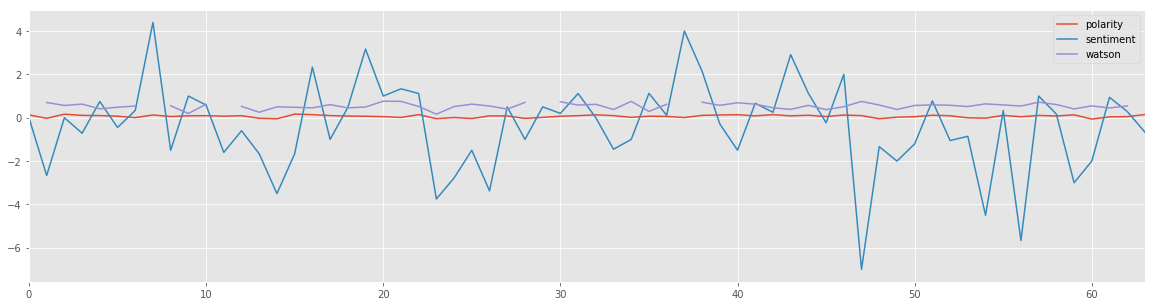

In [50]:
Roche_means_adjusted_df.plot(legend = True, label = 'Daily Sentiment Score', 
                                    figsize = (20, 5))

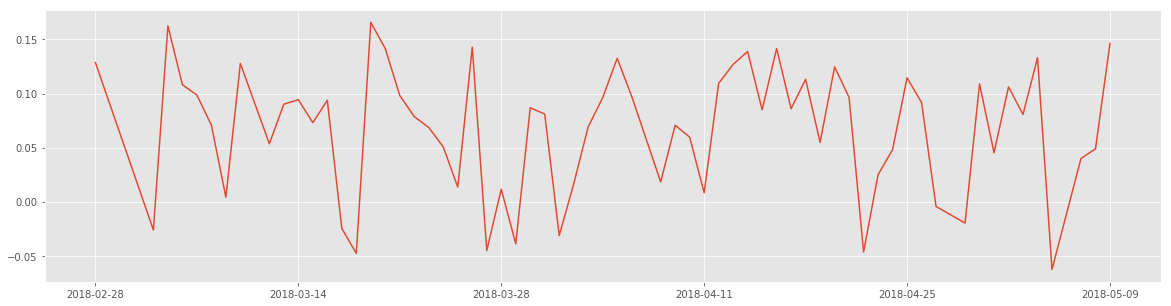

In [51]:
# Plot for Watson Sentiment and Polarity
plt.figure(figsize=(20,5))
plt.plot(Roche_means_adjusted_df['datetime'],Roche_means_adjusted_df['polarity'])
#plt.plot(Roche_means_adjusted_df['datetime'],Roche_means_adjusted_df['watson'])
plt.show()

#### Create Excel File

In [52]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('Roche_df.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
Roche_df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

/Users/Jannick/anaconda3/lib/python3.6/site-packages/xlsxwriter/worksheet.py:830: UserWarning: Ignoring URL 'http://triblive.com/csp/mediapool/sites/dt.common.streams.StreamServer.cls?STREAMOID=PzYjCoa09D2h_AxxIKpqg8$daE2N3K4ZzOUsqbU5sYswC5y_sDLWSCAyuldTS73AWCsjLu883Ygn4B49Lvm9bPe2QeMKQdVeZmXF$9l$4uCZ8QDXhaHEp3rvzXRJFdy0KqPHLoMevcTLo3h8xh70Y6N_U_CryOsw6FTOdKL_jpQ-&amp;CONTENTTYPE=image/jpeg' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))
/Users/Jannick/anaconda3/lib/python3.6/site-packages/xlsxwriter/worksheet.py:830: UserWarning: Ignoring URL 'http://triblive.com/csp/mediapool/sites/dt.common.streams.StreamServer.cls?STREAMOID=PXTLvdTWHeBFMP$wTj7UL8$daE2N3K4ZzOUsqbU5sYtB4QgKQ1qd4ZuVcn8U1vllWCsjLu883Ygn4B49Lvm9bPe2QeMKQdVeZmXF$9l$4uCZ8QDXhaHEp3rvzXRJFdy0KqPHLoMevcTLo3h8xh70Y6N_U_CryOsw6FTOdKL_jpQ-&amp;CONTENTTYPE=image/jpeg' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(

In [53]:
Roche_df.head()

,author,country,crawl_date,enriched_text,enriched_title,external_links,extracted_metadata,forum_title,highlight,host,...,text,title,url,datetime,tokens,num_occurr_pos,num_occurr_neg,num_occurr_lit,num_occurr_unc,sentiment_score
0,Latisha Jones,US,2018-04-05T05:34:32Z,"{'entities': [{'count': 9, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...",NaN,{'sha1': 'd2e730fe19a8eb7d9549e40a1474d18bc183...,Daily Political,{'enriched_text.semantic_roles.object.text': [...,dailypolitical.com,...,Tweet Roche (VTX:ROG) ‘s stock had its “buy” r...,Roche (ROG) Given “Buy” Rating at JPMorgan Chase,https://www.dailypolitical.com/2018/04/04/roch...,2018-04-05 05:16:00,"[tweet, roch, vtx, rog, stock, buy, rate, reis...",0,1,1,0,-1
1,NaN,US,2018-04-19T05:38:01Z,"{'entities': [{'count': 1, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...",NaN,{'sha1': '54e59198dba7b2bc9f0e538b35978326508f...,NaN,{'enriched_text.semantic_roles.object.text': [...,dc101.iheart.com,...,Sphere Of Roche: Does Roche Shower Enough? pos...,Sphere Of Roche: Does Roche Shower Enough? | R...,https://dc101.iheart.com/featured/roche/conten...,2018-04-18 00:00:00,"[sphere, roch, roch, shower, enough, post, roc...",1,2,0,0,-1
2,Joe Pappalardo,US,2018-04-05T05:09:59Z,"{'entities': [{'count': 2, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...",NaN,{'sha1': '11c9111b19f05833f739390db5ab499c2a77...,Hillsdale Collegian,{'enriched_text.semantic_roles.object.text': [...,hillsdalecollegian.com,...,Roche charges $5 for parking Roche charges $5 ...,Roche charges $5 for parking,http://hillsdalecollegian.com/2018/04/roche-ch...,2018-04-04 13:00:00,"[roch, charg, park, roch, charg, park, share, ...",0,0,0,1,0
3,NaN,US,2018-03-08T12:20:13Z,"{'entities': [{'count': 2, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...",NaN,{'sha1': '1451ba2ff7b64fa877c0f0a72d009d8ec952...,"NewsDump.com, US News, Headlines, Latest USA N...",{'enriched_text.relations.arguments.entities.t...,newsdump.com,...,Published By: Reuters - Health - Today ZURICH ...,Roche names Pao as Swiss R&D head after Reed e...,http://www.newsdump.com/article/roche-names-pa...,2018-03-08 11:40:00,"[publish, reuter, health, today, zurich, reute...",0,0,0,0,0
4,Caroline Horne,US,2018-05-01T07:59:45Z,"{'entities': [{'count': 8, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...","[https://www.marketbeat.com/stocks/VTX/ROG/, h...",{'sha1': 'b7da7697fe180ee46a49467b12254bb31a54...,The Lincolnian Online,{'enriched_text.semantic_roles.object.text': [...,thelincolnianonline.com,...,JPMorgan Chase Reaffirms “Buy” Rating for Roch...,JPMorgan Chase Reaffirms “Buy” Rating for Roch...,https://www.thelincolnianonline.com/2018/05/01...,2018-05-01 09:54:00,"[jpmorgan, chase, reaffirm, buy, rate, roch, r...",0,2,1,1,-2


### Novartis: Apply Text Mining Function

In [54]:
# Text mine function for Novartis
def text_mine_articles(Novartis_df, bag_of_words,alignment):
    
    bag_of_words = tokenize(bag_of_words)
    Novartis_df['num_occurr_'+alignment] = 0
    
    # 'Set' to make the counting operation faster
    set_of_words = set(bag_of_words)
    
    print('Text mine articles...'),
    
    for j in range(0, len(Novartis_df)):
        
        # Convert article body into a list of tokens
        tokenized_article = tokenize(Novartis_df['text'][j])
        
        # Count occurrences of the dictionary of words
        occurrences = [word for word in tokenized_article
                        if word in set_of_words]
        
        # Copy amount of occurrences found to the dataframe
        amount = len(occurrences)
        Novartis_df['num_occurr_'+alignment][j] = amount
        
    # Compute frequency of occurrence found in each article dividing
    # the amount of words counted as occurrences by the amount of words in the article
    # UBS_df['freq_occurr_'+alignment] = UBS_df['num_occurr_'+alignment]/UBS_df['word_count']   
   
    print('Done!')
 
    return Novartis_df

In [55]:
# Text mine all articles for each sentiment (positive, negative, litigious, uncertain)
Novartis_df = text_mine_articles(Novartis_df, pos,'pos')
Novartis_df = text_mine_articles(Novartis_df, neg,'neg')
Novartis_df = text_mine_articles(Novartis_df, lit,'lit')
Novartis_df = text_mine_articles(Novartis_df, unc,'unc')

Text mine articles...


/Users/Jannick/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Done!
Text mine articles...
Done!
Text mine articles...
Done!
Text mine articles...
Done!


### Sentiment Score

In [56]:
## Sentiment Score Novartis
# The following function provides a simple function to create a sentiment score
Novartis_df['sentiment_score'] = Novartis_df['num_occurr_pos'] - Novartis_df['num_occurr_neg']

#### Daily Average Score

In [57]:
Novartis_avg_df = pd.read_excel('Sentiment_Score_Novartis.xlsx')
Novartis_avg_df.head()

,publication_date,sentiment_score,watson_sentiment_score,polarity,subjectivity
0,2018-03-03T13:05:00Z,6,0.784469,0.227083,0.433333
1,2018-03-04T05:42:00Z,2,NaN,0.139336,0.248427
2,2018-03-05T00:00:00+01:00,-15,-0.432310,-0.028571,0.466667
3,2018-03-05T00:00:00+01:00,-15,-0.432310,-0.028571,0.466667
4,2018-03-05T05:00:00Z,4,0.788521,0.279167,0.356944


In [58]:
# Transform date into datetime
Novartis_avg_df['datetime'] = pd.to_datetime(Novartis_avg_df['publication_date'])

In [59]:
# Create .dt.date format
Novartis_avg_df['date'] = Novartis_avg_df['datetime'].dt.date

In [60]:
# Creates a function that computes the mean value for each day 
unique_dates = Novartis_avg_df['date'].unique()
Novartis_means_df = pd.DataFrame(unique_dates)

for date in unique_dates:
    same_date = Novartis_avg_df.loc[Novartis_avg_df['date'] == date]
    
    sentiment_mean = same_date['sentiment_score'].mean()
    watson_mean = same_date['watson_sentiment_score'].mean()
    polarity_mean = same_date['polarity'].mean()

    Novartis_means_df = Novartis_means_df.append({'sentiment': sentiment_mean, 'watson': watson_mean, 
                                        'polarity': polarity_mean}, ignore_index=True)

/Users/Jannick/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  del sys.path[0]


In [61]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('Novartis_means_df.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
Novartis_means_df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [62]:
# Open adjusted UBS file containing all sentiment scores 
Novartis_means_adjusted_df = pd.read_excel('Novartis_means__adjusted_df.xlsx')

# Transform date to datetime format
Novartis_means_adjusted_df['datetime'] = pd.to_datetime(Novartis_means_adjusted_df['date'])

# Display head of newly created dataframe
Novartis_means_adjusted_df.head()

,date,polarity,sentiment,watson,datetime
0,2018-03-03,0.227083,6.000000,0.784469,2018-03-03
1,2018-03-04,0.027398,-9.333333,-0.432310,2018-03-04
2,2018-03-05,0.139860,2.750000,0.732827,2018-03-05
3,2018-03-06,-0.003123,-0.333333,0.163667,2018-03-06
4,2018-03-07,0.148205,4.375000,0.524228,2018-03-07


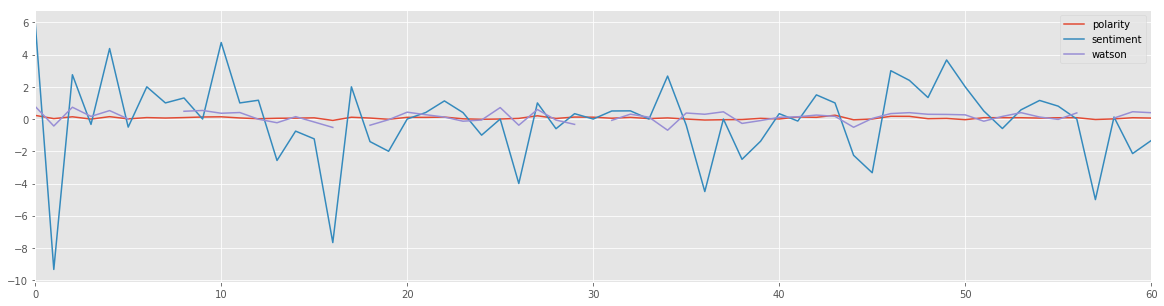

In [63]:
Novartis_means_adjusted_df.plot(legend = True, label = 'Daily Sentiment Score', 
                                    figsize = (20, 5))

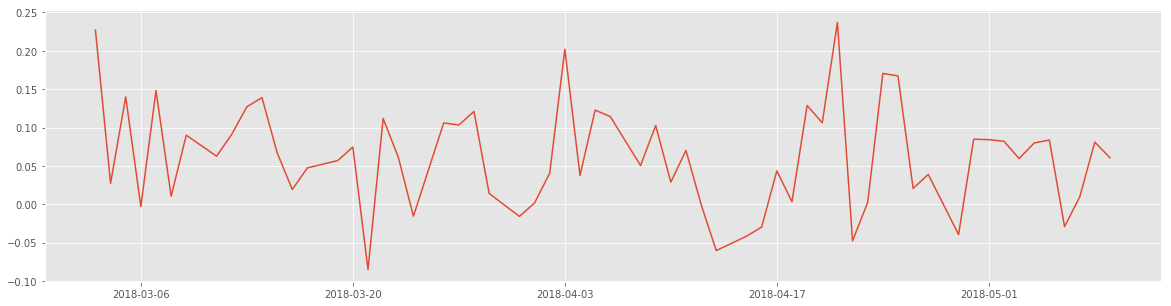

In [64]:
# Plot for Watson Sentiment and Polarity
plt.figure(figsize=(20,5))
plt.plot(Novartis_means_adjusted_df['datetime'],Novartis_means_adjusted_df['polarity'])
# plt.plot(Novartis_means_adjusted_df['datetime'],Novartis_means_adjusted_df['watson'])
plt.show()

#### Create Excel File

In [65]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('Novartis_df.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
Novartis_df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

/Users/Jannick/anaconda3/lib/python3.6/site-packages/xlsxwriter/worksheet.py:830: UserWarning: Ignoring URL 'https://s.yimg.com/uu/api/res/1.2/pZvP6Mua6_1YH6zqqYhHZg--~B/aD01MzM7dz04MDA7c209MTthcHBpZD15dGFjaHlvbg--/http://globalfinance.zenfs.com/images/US_AHTTP_REUTERS_OLUSBUS_WRAPPER_H_LIVE_NEW/2018-04-09T051716Z_2_LYNXMPEE3808T_RTROPTP_3_SWISS-BUSINESS_original.jpg' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))
/Users/Jannick/anaconda3/lib/python3.6/site-packages/xlsxwriter/worksheet.py:830: UserWarning: Ignoring URL 'http://www.channelnewsasia.com/news/heal...h-10146240%20ZURICH:%20Swiss%20pharmaceutical%20giant%20Novartis%20on%20Tuesday%20(Apr%2017)announced%20US$100%20million%20of%20funding%20over%20the%20next%20five%20years%20for%20research%20into%20new%20treatments%20for%20malaria,%20a%20mosquito-borne%20disease%20with%20a%20devastating%20impact%20that%20killed%20445,000%20people%20in%202016.%3cbr/%3e%3cbr/%3eThere%20

In [66]:
Novartis_df.head()

,author,country,crawl_date,enriched_text,enriched_title,external_links,extracted_metadata,forum_title,highlight,host,...,text,title,url,datetime,tokens,num_occurr_pos,num_occurr_neg,num_occurr_lit,num_occurr_unc,sentiment_score
0,NaN,US,2018-03-22T09:22:26Z,"{'entities': [{'count': 3, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...",NaN,{'sha1': '05a21a8dd09f788b7ac1bbd0aa8db1bffd00...,NaN,{'enriched_text.semantic_roles.object.entities...,pharma.remmont.com,...,Posted On Mar 20 2018 by admin Reporting side ...,"Report Side Effects, novartis pharmaceutical.#...",http://pharma.remmont.com/report-side-effects-...,2018-03-20 00:00:00,"[post, mar, admin, report, side, effect, side,...",10,5,1,2,5
1,NaN,CH,2018-05-01T10:15:24Z,"{'entities': [{'count': 17, 'sentiment': {'sco...","{'entities': [{'count': 1, 'sentiment': {'scor...",[http://investors.avexis.com/phoenix.zhtml?c=2...,{'sha1': 'b781074fdad68f34771ce2b64bbaf1ac1b28...,SIX Swiss Exchange | Equity issuer newsfeed,{'enriched_text.semantic_roles.object.entities...,six-swiss-exchange.com,...,01.05.2018 Novartis AG Novartis provides updat...,Novartis AG,http://www.six-swiss-exchange.com/issuers/serv...,2018-05-01 00:00:00,"[novarti, novarti, provid, updat, propos, acqu...",2,2,3,3,0
2,Marc Bisbal,US,2018-03-12T08:29:34Z,"{'entities': [{'count': 1, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...",NaN,{'sha1': '418b62ece773b7a26c1b261b3b93c6a703a7...,T - MarketWatch.com Topics,{'enriched_text.semantic_roles.object.text': [...,marketwatch.com,...,Novartis AG (NOVN.EB) said Monday that it appo...,Novartis president of operations to exit,http://www.marketwatch.com/story/novartis-pres...,2018-03-12 05:00:00,"[novarti, novn.eb, said, monday, appoint, thre...",2,0,0,1,2
3,NaN,GB,2018-03-12T19:33:28Z,"{'entities': [{'count': 18, 'sentiment': {'sco...","{'entities': [{'count': 1, 'sentiment': {'scor...",NaN,{'sha1': '7f90aa8438fb3ab19eeea72ad13f2750d545...,ukcitymedia new uk stock market news,{'enriched_text.semantic_roles.object.entities...,ukcitymedia.co.uk,...,<p>A uk stock market forum. User postings for ...,NOVARTIS FINANCE S.A. : Directorate change,http://www.ukcitymedia.co.uk/cms40/uk-stockmar...,2018-03-12 06:30:00,"[stock, market, forum, user, post, ftse, aim, ...",1,1,0,1,0
4,ConverterNewsMachine,DE,2018-03-08T06:39:33Z,"{'entities': [{'count': 2, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...",NaN,{'sha1': 'f5150340b45d635538c314e25e500284bc10...,"Slitter, converting, labelling and hot melt news",{'enriched_text.relations.arguments.entities.t...,converternews.com,...,Home Novartis teams up with American company t...,Novartis teams up with American company to lau...,http://www.converternews.com/novartis-teams-up...,2018-03-07 17:35:00,"[home, novarti, team, american, compani, launc...",1,0,0,0,1


### ABB: Apply Text Mining Function

In [67]:
# Text mine function for ABB
def text_mine_articles(ABB_df, bag_of_words,alignment):
    
    bag_of_words = tokenize(bag_of_words)
    ABB_df['num_occurr_'+alignment] = 0
    
    # 'Set' to make the counting operation faster
    set_of_words = set(bag_of_words)
    
    print('Text mine articles...'),
    
    for j in range(0, len(ABB_df)):
        
        # Convert article body into a list of tokens
        tokenized_article = tokenize(ABB_df['text'][j])
        
        # Count occurrences of the dictionary of words
        occurrences = [word for word in tokenized_article
                        if word in set_of_words]
        
        # Copy amount of occurrences found to the dataframe
        amount = len(occurrences)
        ABB_df['num_occurr_'+alignment][j] = amount
        
    # Compute frequency of occurrence found in each article dividing
    # the amount of words counted as occurrences by the amount of words in the article
    # UBS_df['freq_occurr_'+alignment] = UBS_df['num_occurr_'+alignment]/UBS_df['word_count']   
   
    print('Done!')
 
    return ABB_df

In [68]:
# Text mine all articles for each sentiment (positive, negative, litigious, uncertain)
ABB_df = text_mine_articles(Roche_df, pos,'pos')
ABB_df = text_mine_articles(Roche_df, neg,'neg')
ABB_df = text_mine_articles(Roche_df, lit,'lit')
ABB_df = text_mine_articles(Roche_df, unc,'unc')

Text mine articles...


/Users/Jannick/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Done!
Text mine articles...
Done!
Text mine articles...
Done!
Text mine articles...
Done!


### Sentiment Score

In [69]:
## Sentiment Score ABB
# The following function provides a simple function to create a sentiment score
ABB_df['sentiment_score'] = ABB_df['num_occurr_pos'] - ABB_df['num_occurr_neg']

#### Daily Average Score

In [70]:
ABB_avg_df = pd.read_excel('Sentiment_Score_ABB.xlsx')
ABB_avg_df.head()

,publication_date,sentiment_score,watson_sentiment_score,polarity,subjectivity
0,2018-02-28T00:00:00Z,0,NaN,0.128571,0.432143
1,2018-02-28T00:00:00Z,0,NaN,0.128571,0.432143
2,2018-03-04T06:10:00Z,-2,0.825222,-0.036458,0.223958
3,2018-03-04T07:52:00Z,-3,0.755137,-0.020833,0.162500
4,2018-03-04T07:52:00Z,-3,0.525230,-0.020833,0.162500


In [71]:
# Transform date into datetime
ABB_avg_df['datetime'] = pd.to_datetime(ABB_avg_df['publication_date'])

In [72]:
# Create .dt.date format
ABB_avg_df['date'] = ABB_avg_df['datetime'].dt.date

In [73]:
# Creates a function that computes the mean value for each day 
unique_dates = ABB_avg_df['date'].unique()
ABB_means_df = pd.DataFrame(unique_dates)

for date in unique_dates:
    same_date = ABB_avg_df.loc[ABB_avg_df['date'] == date]
    
    sentiment_mean = same_date['sentiment_score'].mean()
    watson_mean = same_date['watson_sentiment_score'].mean()
    polarity_mean = same_date['polarity'].mean()

    ABB_means_df = ABB_means_df.append({'sentiment': sentiment_mean, 'watson': watson_mean, 
                                        'polarity': polarity_mean}, ignore_index=True)

/Users/Jannick/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  del sys.path[0]


In [74]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('ABB_means_df.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
ABB_means_df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [75]:
# Open adjusted UBS file containing all sentiment scores 
ABB_means_adjusted_df = pd.read_excel('ABB_means_adjusted_df.xlsx')

# Transform date to datetime format
ABB_means_adjusted_df['datetime'] = pd.to_datetime(ABB_means_adjusted_df['date'])

# Display head of newly created dataframe
ABB_means_adjusted_df.head()

,date,polarity,sentiment,watson,datetime
0,2018-02-28,0.128571,0.000000,NaN,2018-02-28
1,2018-03-04,-0.026042,-2.666667,0.701863,2018-03-04
2,2018-03-05,0.162500,0.000000,0.566140,2018-03-05
3,2018-03-06,0.108170,-0.714286,0.628010,2018-03-06
4,2018-03-07,0.098606,0.750000,0.409668,2018-03-07


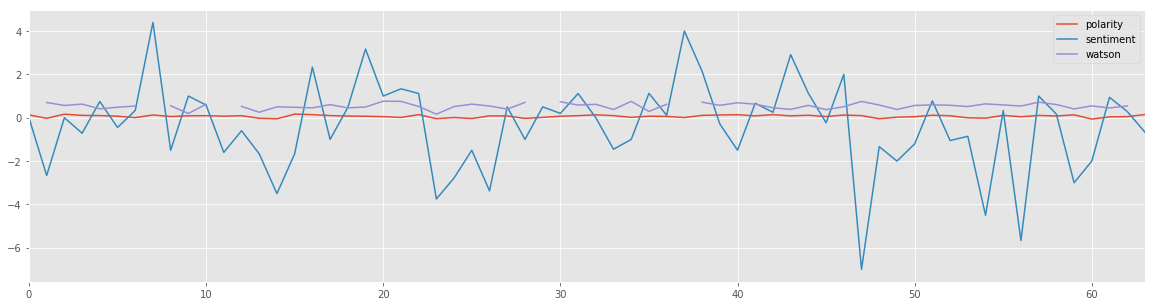

In [76]:
ABB_means_adjusted_df.plot(legend = True, label = 'Daily Sentiment Score', 
                                    figsize = (20, 5))

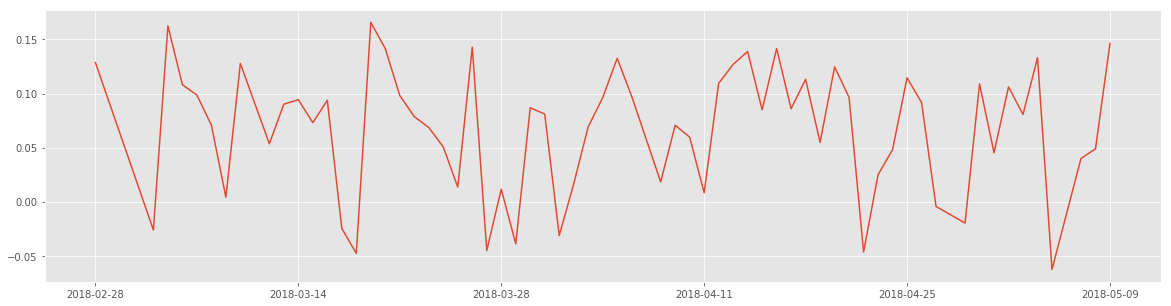

In [77]:
# Plot for Watson Sentiment and Polarity
plt.figure(figsize=(20,5))
plt.plot(ABB_means_adjusted_df['datetime'],ABB_means_adjusted_df['polarity'])
# plt.plot(Novartis_means_adjusted_df['datetime'],Novartis_means_adjusted_df['watson'])
plt.show()

#### Create Excel File

In [78]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('ABB_df.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
ABB_df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

/Users/Jannick/anaconda3/lib/python3.6/site-packages/xlsxwriter/worksheet.py:830: UserWarning: Ignoring URL 'http://triblive.com/csp/mediapool/sites/dt.common.streams.StreamServer.cls?STREAMOID=PzYjCoa09D2h_AxxIKpqg8$daE2N3K4ZzOUsqbU5sYswC5y_sDLWSCAyuldTS73AWCsjLu883Ygn4B49Lvm9bPe2QeMKQdVeZmXF$9l$4uCZ8QDXhaHEp3rvzXRJFdy0KqPHLoMevcTLo3h8xh70Y6N_U_CryOsw6FTOdKL_jpQ-&amp;CONTENTTYPE=image/jpeg' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))
/Users/Jannick/anaconda3/lib/python3.6/site-packages/xlsxwriter/worksheet.py:830: UserWarning: Ignoring URL 'http://triblive.com/csp/mediapool/sites/dt.common.streams.StreamServer.cls?STREAMOID=PXTLvdTWHeBFMP$wTj7UL8$daE2N3K4ZzOUsqbU5sYtB4QgKQ1qd4ZuVcn8U1vllWCsjLu883Ygn4B49Lvm9bPe2QeMKQdVeZmXF$9l$4uCZ8QDXhaHEp3rvzXRJFdy0KqPHLoMevcTLo3h8xh70Y6N_U_CryOsw6FTOdKL_jpQ-&amp;CONTENTTYPE=image/jpeg' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(

In [79]:
ABB_df.head()

,author,country,crawl_date,enriched_text,enriched_title,external_links,extracted_metadata,forum_title,highlight,host,...,text,title,url,datetime,tokens,num_occurr_pos,num_occurr_neg,num_occurr_lit,num_occurr_unc,sentiment_score
0,Latisha Jones,US,2018-04-05T05:34:32Z,"{'entities': [{'count': 9, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...",NaN,{'sha1': 'd2e730fe19a8eb7d9549e40a1474d18bc183...,Daily Political,{'enriched_text.semantic_roles.object.text': [...,dailypolitical.com,...,Tweet Roche (VTX:ROG) ‘s stock had its “buy” r...,Roche (ROG) Given “Buy” Rating at JPMorgan Chase,https://www.dailypolitical.com/2018/04/04/roch...,2018-04-05 05:16:00,"[tweet, roch, vtx, rog, stock, buy, rate, reis...",0,1,1,0,-1
1,NaN,US,2018-04-19T05:38:01Z,"{'entities': [{'count': 1, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...",NaN,{'sha1': '54e59198dba7b2bc9f0e538b35978326508f...,NaN,{'enriched_text.semantic_roles.object.text': [...,dc101.iheart.com,...,Sphere Of Roche: Does Roche Shower Enough? pos...,Sphere Of Roche: Does Roche Shower Enough? | R...,https://dc101.iheart.com/featured/roche/conten...,2018-04-18 00:00:00,"[sphere, roch, roch, shower, enough, post, roc...",1,2,0,0,-1
2,Joe Pappalardo,US,2018-04-05T05:09:59Z,"{'entities': [{'count': 2, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...",NaN,{'sha1': '11c9111b19f05833f739390db5ab499c2a77...,Hillsdale Collegian,{'enriched_text.semantic_roles.object.text': [...,hillsdalecollegian.com,...,Roche charges $5 for parking Roche charges $5 ...,Roche charges $5 for parking,http://hillsdalecollegian.com/2018/04/roche-ch...,2018-04-04 13:00:00,"[roch, charg, park, roch, charg, park, share, ...",0,0,0,1,0
3,NaN,US,2018-03-08T12:20:13Z,"{'entities': [{'count': 2, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...",NaN,{'sha1': '1451ba2ff7b64fa877c0f0a72d009d8ec952...,"NewsDump.com, US News, Headlines, Latest USA N...",{'enriched_text.relations.arguments.entities.t...,newsdump.com,...,Published By: Reuters - Health - Today ZURICH ...,Roche names Pao as Swiss R&D head after Reed e...,http://www.newsdump.com/article/roche-names-pa...,2018-03-08 11:40:00,"[publish, reuter, health, today, zurich, reute...",0,0,0,0,0
4,Caroline Horne,US,2018-05-01T07:59:45Z,"{'entities': [{'count': 8, 'sentiment': {'scor...","{'entities': [{'count': 1, 'sentiment': {'scor...","[https://www.marketbeat.com/stocks/VTX/ROG/, h...",{'sha1': 'b7da7697fe180ee46a49467b12254bb31a54...,The Lincolnian Online,{'enriched_text.semantic_roles.object.text': [...,thelincolnianonline.com,...,JPMorgan Chase Reaffirms “Buy” Rating for Roch...,JPMorgan Chase Reaffirms “Buy” Rating for Roch...,https://www.thelincolnianonline.com/2018/05/01...,2018-05-01 09:54:00,"[jpmorgan, chase, reaffirm, buy, rate, roch, r...",0,2,1,1,-2


## Sentiment Analysis with IBM Alchemy API
The second sentiment analysis is just thought as a benchmark using the advanced methods of natural language processing (NLP) by IBM. For each article within each JSON file, the sentiment score provided by the Alchemy API is extracted and added to the pandas dataframe. 

### Sentiment Score of UBS

In [80]:
# UBS sentiment score from Watson Discovery News
UBS_watson_sentiment = []
for x in range(0,347):
    UBS_watson_sentiment.append(UBS_json['results'][x]['enriched_text']['sentiment']['document']['score'])
UBS_df['watson_sentiment_score'] = pd.Series(UBS_watson_sentiment)

### Sentiment Score of Nestle

In [81]:
# Nestle sentiment score from Watson Discovery News
Nestle_watson_sentiment = []
for x in range(0,347):
    Nestle_watson_sentiment.append(Nestle_json['results'][x]['enriched_text']['sentiment']['document']['score'])
Nestle_df['watson_sentiment_score'] = pd.Series(Nestle_watson_sentiment)

### Sentiment Score of Roche

In [82]:
# Roche sentiment score from Watson Discovery News
Roche_watson_sentiment = []
for x in range(0,347):
    Roche_watson_sentiment.append(Roche_json['results'][x]['enriched_text']['sentiment']['document']['score'])
Roche_df['watson_sentiment_score'] = pd.Series(Roche_watson_sentiment)

### Sentiment Score of Novartis

In [83]:
# Novartis sentiment score from Watson Discovery News
Novartis_watson_sentiment = []
for x in range(0,347):
    Novartis_watson_sentiment.append(Novartis_json['results'][x]['enriched_text']['sentiment']['document']['score'])
Novartis_df['watson_sentiment_score'] = pd.Series(Novartis_watson_sentiment)

### Sentiment Score of ABB

In [84]:
# ABB sentiment score from Watson Discovery News
ABB_watson_sentiment = []
for x in range(0,347):
    ABB_watson_sentiment.append(ABB_json['results'][x]['enriched_text']['sentiment']['document']['score'])
ABB_df['watson_sentiment_score'] = pd.Series(ABB_watson_sentiment) 

## Sentiment Analysis with TextBlob
The third sentiment analysis uses TextBlob which is a Python library for processing textual data. Textblob "provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more."

As an addition I will try to analyse the subjectivity of each article using the TextBlob library. The sentiment analysis using Textblob thus consists of two scores:


__Polarity__: Sentiment Score (positive or negative)

__Subjectivity__: Score if text is subjective or not

### Sentiment Score of UBS

In [85]:
# The x in the lambda function is a row (because I set axis=1)
# Apply iterates the function accross the dataframe's rows
UBS_df['polarity'] = UBS_df.apply(lambda x: TextBlob(x['text']).sentiment.polarity, axis=1)
UBS_df['subjectivity'] = UBS_df.apply(lambda x: TextBlob(x['text']).sentiment.subjectivity, axis=1)

### Sentiment Score of Nestle

In [86]:
# The x in the lambda function is a row (because I set axis=1)
# Apply iterates the function accross the dataframe's rows
Nestle_df['polarity'] = Nestle_df.apply(lambda x: TextBlob(x['text']).sentiment.polarity, axis=1)
Nestle_df['subjectivity'] = Nestle_df.apply(lambda x: TextBlob(x['text']).sentiment.subjectivity, axis=1)

### Sentiment Score of Roche

In [87]:
# The x in the lambda function is a row (because I set axis=1)
# Apply iterates the function accross the dataframe's rows
Roche_df['polarity'] = Roche_df.apply(lambda x: TextBlob(x['text']).sentiment.polarity, axis=1)

### Sentiment Score of Novartis

In [88]:
# The x in the lambda function is a row (because I set axis=1)
# Apply iterates the function accross the dataframe's rows
Novartis_df['polarity'] = Novartis_df.apply(lambda x: TextBlob(x['text']).sentiment.polarity, axis=1)
Novartis_df['subjectivity'] = Novartis_df.apply(lambda x: TextBlob(x['text']).sentiment.subjectivity, axis=1)

### Sentiment Score of ABB

In [89]:
# The x in the lambda function is a row (because I set axis=1)
# Apply iterates the function accross the dataframe's rows
ABB_df['polarity'] = ABB_df.apply(lambda x: TextBlob(x['text']).sentiment.polarity, axis=1)
ABB_df['subjectivity'] = ABB_df.apply(lambda x: TextBlob(x['text']).sentiment.subjectivity, axis=1)

## Sentiment Index with NZZ Articles

## Analysis of UBS

### NZZ Online: Articles of Past 2 Months

In [90]:
a_list = []
for n in range(1,5):    
    sauce = open('UBS_NZZ_'+str(n)+'.htm','rb')
    soup = BeautifulSoup(sauce,'html.parser')
    content = soup.find_all('div',{'class':'singleDocument modulePageBreak'})
    #count=1
    for i in content:
        #print(count)
        time = i.find_all('pre',{'class':'gray'})[0].text
        #title = i.find_all('pre',{'class':'boldLarge'})[0].text
        text = i.find_all('pre',{'class':'text'})[0].text
        teatime = ''
        for j in time:
            if j.isdigit() == True or j == '.':
                teatime += j
        time = teatime[:10]
        #count+=1
        
        a_list.append([time,text])


In [91]:
some_df = pd.DataFrame(a_list,columns=['date','text'])
some_df.head()

,date,text
0,16.05.2018,"Daniel Fritzsche\n\nEs ist ein idyllisches, ab..."
1,16.05.2018,Partnerschaft im Zahlungsverkehr
2,12.05.2018,UND\nSCHWEIZERISCHES HANDELSBLATT\nGegründet 1...
3,12.05.2018,(awp) · Der Schweizer Aktienmarkt hat am Freit...
4,12.05.2018,Hansueli Schöchli\n\nDie Subtilitäten der Geld...


### Sentiment Analysis with Textblob

In [92]:
# The x in the lambda function is a row (because I set axis=1)
# Apply iterates the function accross the dataframe's rows
some_df['polarity'] = some_df.apply(lambda x: TextBlob(x['text']).sentiment.polarity, axis=1)
some_df['subjectivity'] = some_df.apply(lambda x: TextBlob(x['text']).sentiment.subjectivity, axis=1)

In [93]:
# Create .dt.date format
some_df['datetime'] = pd.to_datetime(some_df['date'],format='%d.%m.%Y')
some_df.at[0,'datetime']
some_df.head()

,date,text,polarity,subjectivity,datetime
0,16.05.2018,"Daniel Fritzsche\n\nEs ist ein idyllisches, ab...",0.150000,0.481250,2018-05-16
1,16.05.2018,Partnerschaft im Zahlungsverkehr,0.000000,0.000000,2018-05-16
2,12.05.2018,UND\nSCHWEIZERISCHES HANDELSBLATT\nGegründet 1...,0.003168,0.090737,2018-05-12
3,12.05.2018,(awp) · Der Schweizer Aktienmarkt hat am Freit...,-0.050000,0.100000,2018-05-12
4,12.05.2018,Hansueli Schöchli\n\nDie Subtilitäten der Geld...,0.000000,0.750000,2018-05-12


In [94]:
# Creates a function that computes the mean value for each day 
unique_dates = some_df['date'].unique()

some_other_df = pd.DataFrame()

for date in unique_dates:
    
    same_date = some_df.loc[some_df['date'] == date]
    polarity_mean = same_date['polarity'].mean()
    subjectivity_mean = same_date['subjectivity'].mean()
    some_other_df = some_other_df.append({'date': date,'polarity': polarity_mean, 
                                          'subjectivity': subjectivity_mean}, ignore_index=True)


In [95]:
some_other_df['date']=pd.to_datetime(some_other_df['date'],format='%d.%m.%Y')
some_other_df.sort_values(by='date').head()

,date,polarity,subjectivity
50,2018-03-11,0.250000,0.525000
49,2018-03-13,0.100000,0.350000
48,2018-03-14,0.050000,0.350000
47,2018-03-17,0.001056,0.190246
46,2018-03-18,0.000000,0.000000


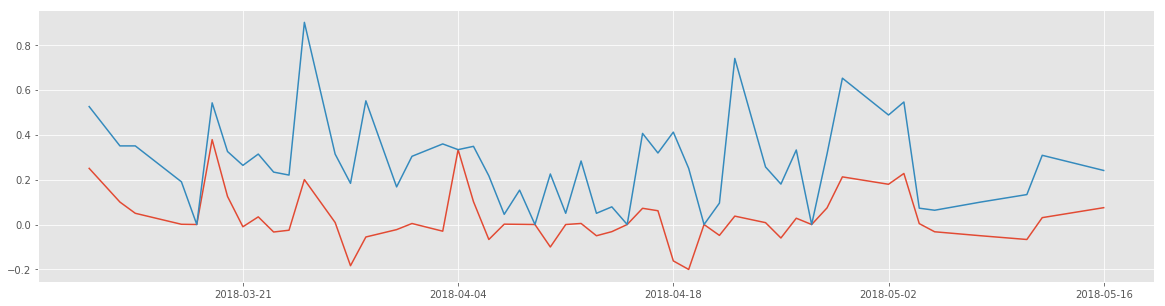

In [96]:
# Plot for Watson Sentiment and Polarity
plt.figure(figsize=(20,5))
plt.plot(some_other_df['date'],some_other_df['polarity'])
plt.plot(some_other_df['date'],some_other_df['subjectivity'])
plt.show()

## NZZ Online: Articles of Past 2 Years

### Loading Articles

In [82]:
a_list = []
for n in range(1,9):    
    sauce = open('UBS_NZZ_Full'+str(n)+'.htm','rb')
    soup = BeautifulSoup(sauce,'html.parser')
    content = soup.find_all('div',{'class':'singleDocument modulePageBreak'})
    #count=1
    for i in content:
        #print(count)
        time = i.find_all('pre',{'class':'gray'})[0].text
        #title = i.find_all('pre',{'class':'boldLarge'})[0].text
        text = i.find_all('pre',{'class':'text'})[0].text
        teatime = ''
        for j in time:
            if j.isdigit() == True or j == '.':
                teatime += j
        time = teatime[:10]
        #count+=1
        
        a_list.append([time,text])


In [83]:
UBS_NZZ_df = pd.DataFrame(a_list,columns=['date','text'])
UBS_NZZ_df.head()

,date,text
0,16.05.2018,"Matthias Müller, Peking\n\nDie UBS hat vor zwe..."
1,12.05.2018,Die Regionalbanken fühlen\nsich vom Branchenve...
2,04.05.2018,Ermes Gallarotti\n\nDie UBS will ihren Anteil ...
3,27.04.2018,Starkes Investment Banking
4,26.04.2018,(awp) · Der Schweizer Aktienmarkt hat am Mittw...


## Sentiment Analysis with Textblob

In [84]:
# The x in the lambda function is a row (because I set axis=1)
# Apply iterates the function accross the dataframe's rows
UBS_NZZ_df['polarity'] = UBS_NZZ_df.apply(lambda x: TextBlob(x['text']).sentiment.polarity, axis=1)
UBS_NZZ_df['subjectivity'] = UBS_NZZ_df.apply(lambda x: TextBlob(x['text']).sentiment.subjectivity, axis=1)

In [100]:
# Create .dt.date format
UBS_NZZ_df['datetime'] = pd.to_datetime(UBS_NZZ_df['date'],format='%d.%m.%Y')
UBS_NZZ_df.at[0,'datetime']
UBS_NZZ_df.head()

,date,text,polarity,subjectivity,datetime
0,16.05.2018,"Matthias Müller, Peking\n\nDie UBS hat vor zwe...",0.384848,0.630303,2018-05-16
1,12.05.2018,Die Regionalbanken fühlen\nsich vom Branchenve...,0.000000,0.000000,2018-05-12
2,04.05.2018,Ermes Gallarotti\n\nDie UBS will ihren Anteil ...,0.000000,0.000000,2018-05-04
3,27.04.2018,Starkes Investment Banking,0.000000,0.000000,2018-04-27
4,26.04.2018,(awp) · Der Schweizer Aktienmarkt hat am Mittw...,-0.050000,0.100000,2018-04-26


In [101]:
# Creates a function that computes the mean value for each day 
unique_dates = UBS_NZZ_df['date'].unique()

UBS_NZZ_New_df = pd.DataFrame()

for date in unique_dates:
    
    same_date = UBS_NZZ_df.loc[UBS_NZZ_df['date'] == date]
    polarity_mean = same_date['polarity'].mean()
    subjectivity_mean = same_date['subjectivity'].mean()
    UBS_NZZ_New_df = UBS_NZZ_New_df.append({'date': date,'polarity': polarity_mean, 
                                          'subjectivity': subjectivity_mean}, ignore_index=True)


In [102]:
UBS_NZZ_New_df['date']=pd.to_datetime(UBS_NZZ_New_df['date'],format='%d.%m.%Y')
UBS_NZZ_New_df.sort_values(by='date').head()

,date,polarity,subjectivity
256,2016-05-28,0.000000,0.300000
255,2016-06-02,0.005556,0.145833
254,2016-06-04,0.000000,0.000000
253,2016-06-10,0.000000,0.000000
252,2016-06-15,-0.093182,0.411364


In [103]:
# Create a rolling mean for the
UBS_NZZ_New_df['polarity_rolling'] = UBS_NZZ_New_df['polarity'].rolling(10).mean()

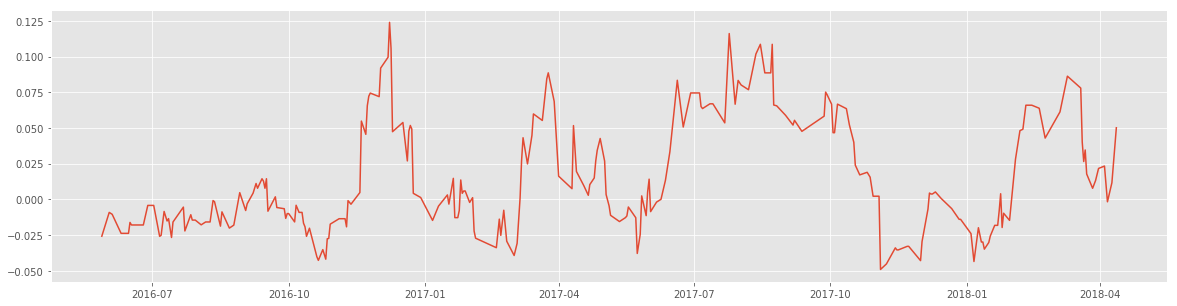

In [104]:
# Plot for Watson Sentiment and Polarity
plt.figure(figsize=(20,5))
#plt.plot(UBS_NZZ_New_df['date'],UBS_NZZ_New_df['polarity'])
plt.plot(UBS_NZZ_New_df['date'],UBS_NZZ_New_df['polarity_rolling'])
#plt.plot(UBS_NZZ_New_df['date'],UBS_NZZ_New_df['subjectivity'])
plt.show()

## Sentiment Analysis with SentiWS Dictionary

In [85]:
# Tokenize and stop words removal
def tokenize(text):

    # Convert to lower case
    words = map(lambda word: word.lower(), word_tokenize(text))
    
    # Remove stop words
    cachedStopWords = stopwords.words("german")
    words = [word for word in words
                  if word not in cachedStopWords]
    
    # Steam the words
    tokens =(list(map(lambda token: PorterStemmer().stem(token), words)))
    
    # Remove non-letters 
    p = re.compile('[a-zA-Z]+')
    
    # Remove less than 3 length words
    min_length = 3
    filtered_tokens = list(filter(lambda token: p.match(token) and len(token) >= min_length, tokens))
    
    return filtered_tokens

In [86]:
# Apply tokenizer to UBS
UBS_NZZ_df['tokens'] = UBS_NZZ_df['text'].apply(tokenize)

In [87]:
def get_words(name):
    words = ''
    weights = []
    with open(name,'r') as f:
        for row in f:
            word = ''
            weight = ''
            mode = 0
            for i in row:
                if mode == 0:
                    if i == '|':
                        mode = 1
                    else:
                        word += i
                if mode in [1,2]:
                    if i in ['-','.'] or i.isnumeric():
                        weight += i
                        mode=2
                    if mode == 2:
                        if i.isspace():
                            words += word + '\n'
                            weights.append(float(weight))
                            break

    
    return words, weights
pos_words,pos_weights = get_words('SentiWS_v1.8c_Positive.txt')
neg_words,neg_weights = get_words('SentiWS_v1.8c_Negative.txt')


In [108]:
# Text mine function for UBS
def text_mine_articles(UBS_NZZ_df, bag_of_words,weights,alignment):
    
    bag_of_words = tokenize(bag_of_words)


    UBS_NZZ_df['num_occurr_'+alignment] = 0
    
    # 'Set' to make the counting operation faster
    set_of_words = set(bag_of_words)
    
    print('Text mine articles...'),
    count=0
    for j in range(0, len(UBS_NZZ_df)):
        # Convert article body into a list of tokens
        tokenized_article = tokenize(UBS_NZZ_df['text'][j])
        
        # Count occurrences of the dictionary of words
        occurrences = [word for word in tokenized_article
                        if word in set_of_words]
        amount = 0
        count_2 = 0
        for word in occurrences:
            
            index = bag_of_words.index(word)
            weight = weights[index]

            amount += weight
            count_2+=1
        # Copy amount of occurrences found to the dataframe
        #amount = len(occurrences)
        UBS_NZZ_df.at[j,'num_occurr_'+alignment] = amount*10000
        count+=1
    # Compute frequency of occurrence found in each article dividing
    # the amount of words counted as occurrences by the amount of words in the article
    # UBS_df['freq_occurr_'+alignment] = UBS_df['num_occurr_'+alignment]/UBS_df['word_count']   
   
    print('Done!')
 
    return UBS_NZZ_df

In [109]:
UBS_NZZ_df = text_mine_articles(UBS_NZZ_df, pos_words,pos_weights,'pos')
UBS_NZZ_df['num_occurr_pos'] = UBS_NZZ_df['num_occurr_pos']/ 10000
UBS_NZZ_df = text_mine_articles(UBS_NZZ_df, neg_words, neg_weights,'neg')
UBS_NZZ_df['num_occurr_neg'] = UBS_NZZ_df['num_occurr_neg']/ 10000

Text mine articles...
Done!
Text mine articles...
Done!


In [110]:
UBS_NZZ_df

,date,text,polarity,subjectivity,tokens,num_occurr_pos,num_occurr_neg
0,16.05.2018,"Matthias Müller, Peking\n\nDie UBS hat vor zwe...",0.384848,0.630303,"[matthia, müller, peke, zwei, wochen, anfang, ...",0.2151,-1.2453
1,12.05.2018,Die Regionalbanken fühlen\nsich vom Branchenve...,0.000000,0.000000,"[regionalbanken, fühlen, branchenverband, bank...",1.4830,-4.0102
2,04.05.2018,Ermes Gallarotti\n\nDie UBS will ihren Anteil ...,0.000000,0.000000,"[erm, gallarotti, anteil, chinesischen, joint,...",0.6285,-0.0461
3,27.04.2018,Starkes Investment Banking,0.000000,0.000000,"[stark, invest, bank]",0.0040,0.0000
4,26.04.2018,(awp) · Der Schweizer Aktienmarkt hat am Mittw...,-0.050000,0.100000,"[awp, schweizer, aktienmarkt, mittwoch, minu, ...",0.4668,-0.9983
5,26.04.2018,Herausgegriffen,0.000000,0.000000,[herausgegriffen],0.0000,0.0000
6,26.04.2018,"Martin Lanz, Washington\n\nAmerikanische Gesch...",0.136364,0.454545,"[martin, lanz, washington, amerikanisch, gesch...",0.0991,-2.1367
7,24.04.2018,Hart geprüfte Aktionäre,0.000000,0.000000,"[hart, geprüft, aktionär]",0.0000,-0.1482
8,24.04.2018,(awp) · Der Schweizer Aktienmarkt ist mit weni...,-0.100000,0.100000,"[awp, schweizer, aktienmarkt, wenig, verändert...",0.3876,-1.1558
9,24.04.2018,Ermes Gallarotti\n\nDie UBS ist gut in das neu...,0.200000,0.600000,"[erm, gallarotti, gut, neue, geschäftsjahr, ge...",1.0821,-1.1684


In [113]:
## Sentiment Score Roche
# The following function provides a simple function to create a sentiment score
UBS_NZZ_df['sentiment_score'] = UBS_NZZ_df['num_occurr_pos'] + UBS_NZZ_df['num_occurr_neg']

In [114]:
# Create .dt.date format
UBS_NZZ_df['datetime'] = pd.to_datetime(UBS_NZZ_df['date'],format='%d.%m.%Y')
UBS_NZZ_df.at[0,'datetime']
UBS_NZZ_df

,date,text,polarity,subjectivity,tokens,num_occurr_pos,num_occurr_neg,sentiment_score,datetime
0,16.05.2018,"Matthias Müller, Peking\n\nDie UBS hat vor zwe...",0.384848,0.630303,"[matthia, müller, peke, zwei, wochen, anfang, ...",0.2151,-1.2453,-1.0302,2018-05-16
1,12.05.2018,Die Regionalbanken fühlen\nsich vom Branchenve...,0.000000,0.000000,"[regionalbanken, fühlen, branchenverband, bank...",1.4830,-4.0102,-2.5272,2018-05-12
2,04.05.2018,Ermes Gallarotti\n\nDie UBS will ihren Anteil ...,0.000000,0.000000,"[erm, gallarotti, anteil, chinesischen, joint,...",0.6285,-0.0461,0.5824,2018-05-04
3,27.04.2018,Starkes Investment Banking,0.000000,0.000000,"[stark, invest, bank]",0.0040,0.0000,0.0040,2018-04-27
4,26.04.2018,(awp) · Der Schweizer Aktienmarkt hat am Mittw...,-0.050000,0.100000,"[awp, schweizer, aktienmarkt, mittwoch, minu, ...",0.4668,-0.9983,-0.5315,2018-04-26
5,26.04.2018,Herausgegriffen,0.000000,0.000000,[herausgegriffen],0.0000,0.0000,0.0000,2018-04-26
6,26.04.2018,"Martin Lanz, Washington\n\nAmerikanische Gesch...",0.136364,0.454545,"[martin, lanz, washington, amerikanisch, gesch...",0.0991,-2.1367,-2.0376,2018-04-26
7,24.04.2018,Hart geprüfte Aktionäre,0.000000,0.000000,"[hart, geprüft, aktionär]",0.0000,-0.1482,-0.1482,2018-04-24
8,24.04.2018,(awp) · Der Schweizer Aktienmarkt ist mit weni...,-0.100000,0.100000,"[awp, schweizer, aktienmarkt, wenig, verändert...",0.3876,-1.1558,-0.7682,2018-04-24
9,24.04.2018,Ermes Gallarotti\n\nDie UBS ist gut in das neu...,0.200000,0.600000,"[erm, gallarotti, gut, neue, geschäftsjahr, ge...",1.0821,-1.1684,-0.0863,2018-04-24


In [115]:
# Creates a function that computes the mean value for each day 
unique_dates = UBS_NZZ_df['date'].unique()

UBS_NZZ_other_df = pd.DataFrame()

for date in unique_dates:
    
    same_date = UBS_NZZ_df.loc[UBS_NZZ_df['date'] == date]
    sentiment_mean = same_date['sentiment_score'].mean()
    UBS_NZZ_other_df = UBS_NZZ_other_df.append({'date': date,'sentiment': sentiment_mean}, ignore_index=True)


In [116]:
UBS_NZZ_other_df['date']=pd.to_datetime(UBS_NZZ_other_df['date'],format='%d.%m.%Y')
UBS_NZZ_other_df.sort_values(by='date').head()

,date,sentiment
256,2016-05-28,-0.938100
255,2016-06-02,-1.316367
254,2016-06-04,0.000000
253,2016-06-10,0.670200
252,2016-06-15,-0.657200


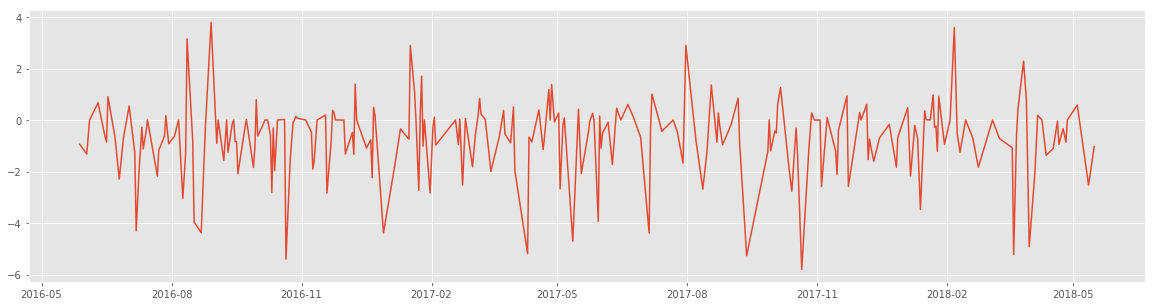

In [117]:
# Plot for Watson Sentiment and Polarity
plt.figure(figsize=(20,5))
plt.plot(UBS_NZZ_other_df['date'],UBS_NZZ_other_df['sentiment'])
plt.show()

In [138]:
UBS_NZZ_other_df['Sentiment_rolling'] = UBS_NZZ_other_df['sentiment'].rolling(10).mean()

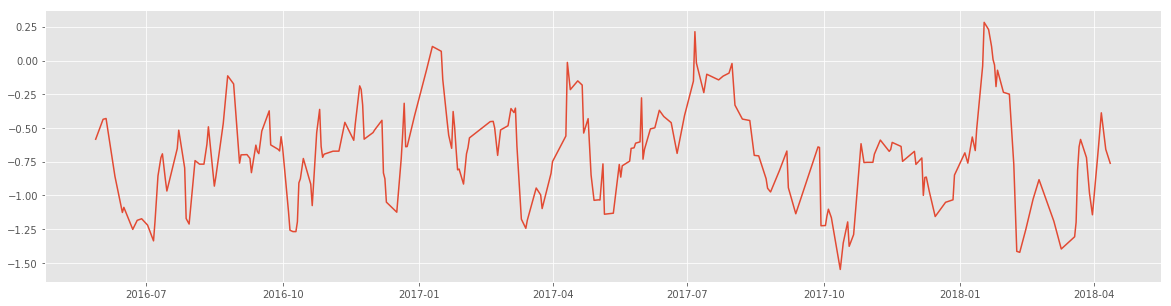

In [139]:
plt.figure(figsize=(20,5))
#plt.plot(FinSent_df['Sentiment'])
plt.plot(UBS_NZZ_other_df['date'],UBS_NZZ_other_df['Sentiment_rolling'])
#plt.plot(FinSent_df['Sentiment High'])
#plt.plot(FinSent_df['Sentiment Low'])
plt.plot()
plt.show()

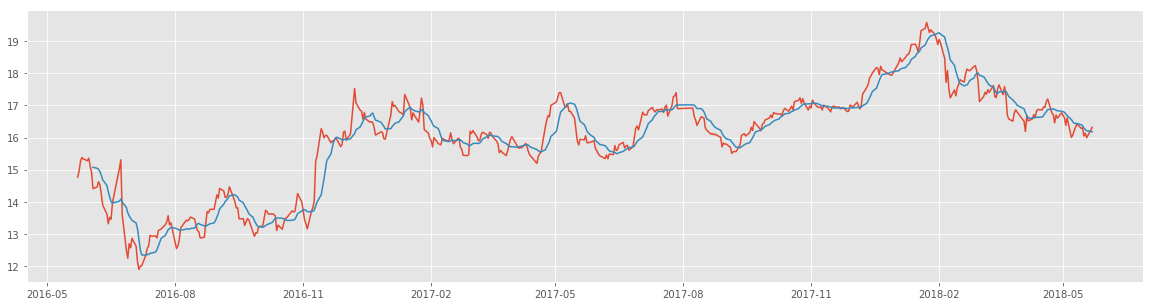

In [140]:
# Plot for UBS
plt.figure(figsize=(20,5))
plt.plot(UBS_quandl_df['Price'])
plt.plot(UBS_quandl_df['Price_rolling'])
plt.plot()
plt.show()

## Analysis of Nestle

### Loading Articles

In [116]:
a_list = []
for n in range(1,17):    
    sauce = open('Nestle_NZZ_Full'+str(n)+'.htm','rb')
    soup = BeautifulSoup(sauce,'html.parser')
    content = soup.find_all('div',{'class':'singleDocument modulePageBreak'})
    #count=1
    for i in content:
        #print(count)
        time = i.find_all('pre',{'class':'gray'})[0].text
        #title = i.find_all('pre',{'class':'boldLarge'})[0].text
        text = i.find_all('pre',{'class':'text'})[0].text
        teatime = ''
        for j in time:
            if j.isdigit() == True or j == '.':
                teatime += j
        time = teatime[:10]
        #count+=1
        
        a_list.append([time,text])

In [117]:
Nestle_NZZ_df = pd.DataFrame(a_list,columns=['date','text'])
Nestle_NZZ_df.head()

,date,text
0,20.05.2018,Kleine und mittlere global tätige Unternehmen ...
1,19.05.2018,(awp) · Der Schweizer Aktienmarkt hat am Freit...
2,15.05.2018,Der Schwarze Kontinent hat schon viele Investo...
3,12.05.2018,Konzernverantwortungsinitiative
4,09.05.2018,(awp) · Der Schweizer Aktienmarkt hat am Diens...


### Sentiment Analysis with Textblob

In [118]:
# The x in the lambda function is a row (because I set axis=1)
# Apply iterates the function accross the dataframe's rows
Nestle_NZZ_df['polarity'] = Nestle_NZZ_df.apply(lambda x: TextBlob(x['text']).sentiment.polarity, axis=1)
Nestle_NZZ_df['subjectivity'] = Nestle_NZZ_df.apply(lambda x: TextBlob(x['text']).sentiment.subjectivity, axis=1)

In [119]:
# Create .dt.date format
Nestle_NZZ_df['datetime'] = pd.to_datetime(Nestle_NZZ_df['date'],format='%d.%m.%Y')
Nestle_NZZ_df.at[0,'datetime']
Nestle_NZZ_df.head()

,date,text,polarity,subjectivity,datetime
0,20.05.2018,Kleine und mittlere global tätige Unternehmen ...,-0.066667,0.346667,2018-05-20
1,19.05.2018,(awp) · Der Schweizer Aktienmarkt hat am Freit...,-0.100000,0.225000,2018-05-19
2,15.05.2018,Der Schwarze Kontinent hat schon viele Investo...,-0.200000,0.600000,2018-05-15
3,12.05.2018,Konzernverantwortungsinitiative,0.000000,0.000000,2018-05-12
4,09.05.2018,(awp) · Der Schweizer Aktienmarkt hat am Diens...,-0.200000,0.600000,2018-05-09


In [120]:
# Creates a function that computes the mean value for each day 
unique_dates = Nestle_NZZ_df['date'].unique()

Nestle_NZZ_New_df = pd.DataFrame()

for date in unique_dates:
    
    same_date = Nestle_NZZ_df.loc[Nestle_NZZ_df['date'] == date]
    polarity_mean = same_date['polarity'].mean()
    subjectivity_mean = same_date['subjectivity'].mean()
    Nestle_NZZ_New_df = Nestle_NZZ_New_df.append({'date': date,'polarity': polarity_mean, 
                                          'subjectivity': subjectivity_mean}, ignore_index=True)


In [121]:
Nestle_NZZ_New_df['date']=pd.to_datetime(Nestle_NZZ_New_df['date'],format='%d.%m.%Y')
Nestle_NZZ_New_df.sort_values(by='date').head()

,date,polarity,subjectivity
464,2016-05-24,0.227273,0.545455
463,2016-05-27,0.000000,0.000000
462,2016-05-28,0.100000,0.350000
461,2016-05-31,0.100000,0.300000
460,2016-06-01,-0.200000,0.600000


In [122]:
Nestle_NZZ_New_df['polarity_rolling'] = Nestle_NZZ_New_df['polarity'].rolling(10).mean()

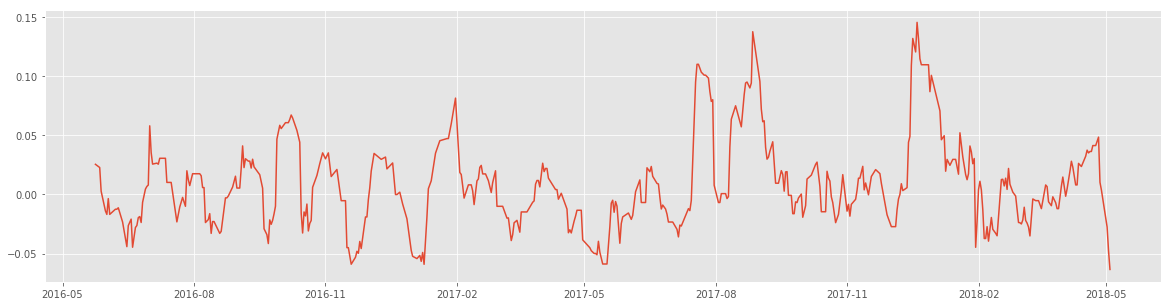

In [123]:
# Plot for Watson Sentiment and Polarity
plt.figure(figsize=(20,5))
plt.plot(Nestle_NZZ_New_df['date'], Nestle_NZZ_New_df['polarity_rolling'])
plt.show()

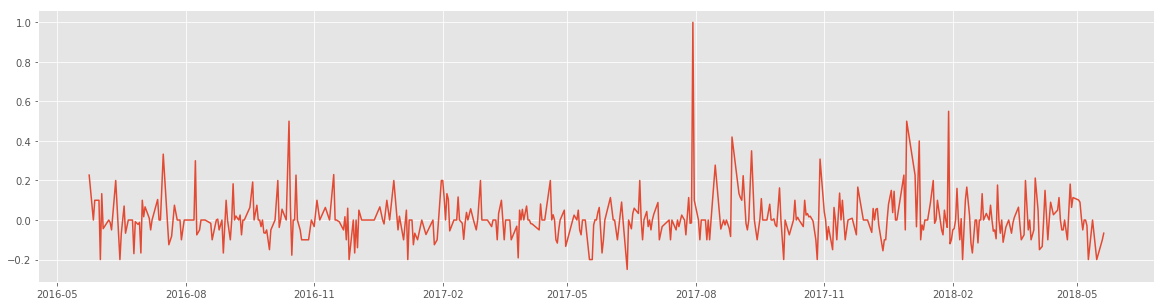

In [124]:
# Plot for Watson Sentiment and Polarity
plt.figure(figsize=(20,5))
plt.plot(Nestle_NZZ_New_df['date'],Nestle_NZZ_New_df['polarity'])
#plt.plot(Nestle_NZZ_New_df['date'],Nestle_NZZ_New_df['subjectivity'])
plt.show()

## Sentiment Analysis with SentiWS Dictionary

In [125]:
# Tokenize and stop words removal
def tokenize(text):

    # Convert to lower case
    words = map(lambda word: word.lower(), word_tokenize(text))
    
    # Remove stop words
    cachedStopWords = stopwords.words("german")
    words = [word for word in words
                  if word not in cachedStopWords]
    
    # Steam the words
    tokens =(list(map(lambda token: PorterStemmer().stem(token), words)))
    
    # Remove non-letters 
    p = re.compile('[a-zA-Z]+')
    
    # Remove less than 3 length words
    min_length = 3
    filtered_tokens = list(filter(lambda token: p.match(token) and len(token) >= min_length, tokens))
    
    return filtered_tokens

In [126]:
# Apply tokenizer to UBS
Nestle_NZZ_df['tokens'] = Nestle_NZZ_df['text'].apply(tokenize)

In [127]:
Nestle_NZZ_df['tokens'][0]

['klein',
 'mittler',
 'global',
 'tätige',
 'unternehmen',
 'stark',
 'foku',
 'finanzbranch',
 'grossen',
 'sorgen',
 'hie',
 'grossen',
 'bühne',
 'schlagzeilen',
 'firma',
 'dätwyler',
 'altdorf',
 'beispielsweis',
 'verlängert',
 'grossauftrag',
 'nespresso',
 'erfolgsmeldung',
 'lautet',
 'tesla',
 'schliesst',
 'dreijahresvertrag',
 'bossard',
 'list',
 'erfreulich',
 'meldungen',
 'lang',
 'gehören',
 'schweizer',
 'börse',
 'kotierten',
 'unternehmen',
 'mittelgrossen',
 'firmen',
 'mid',
 'cap',
 'kleinen',
 'small',
 'cap',
 'stattlich',
 'kursgewinn',
 'mittleren',
 'kleinen',
 'schweizer',
 'aktien',
 'vergangenen',
 'fünf',
 'jahren',
 'fast',
 'unheimlichen',
 'börsenlauf',
 'schnitt',
 'dividenden',
 'eingerechnet',
 'pro',
 'jahr',
 'fast',
 'zugelegt',
 'geht',
 'datenreihen',
 'zurück',
 'anfang',
 'weisen',
 'gemäss',
 'marc',
 'possa',
 'manag',
 'sara',
 'select',
 'fond',
 'klein',
 'firmen',
 'jährlich',
 'fast',
 'besser',
 'perform',
 'ganz',
 'grossen',
 'imm

In [128]:
with open('Bannier_Positive.csv', 'r') as f: 
    pos = ''
    for row in f:
        pos += row.replace('\n',',')
with open('Bannier_Negative.csv', 'r') as f: 
    neg = ''
    for row in f:
        neg += row.replace('\n',',')

In [129]:
# Text mine function for Nestle
def text_mine_articles(Nestle_NZZ_df, bag_of_words,alignment):
    
    bag_of_words = tokenize(bag_of_words)
    Nestle_NZZ_df['num_occurr_'+alignment] = 0
    
    # 'Set' to make the counting operation faster
    set_of_words = set(bag_of_words)
    
    print('Text mine articles...'),
    
    for j in range(0, len(Nestle_NZZ_df)):
        
        # Convert article body into a list of tokens
        tokenized_article = tokenize(Nestle_NZZ_df['text'][j])
        
        # Count occurrences of the dictionary of words
        occurrences = [word for word in tokenized_article
                        if word in set_of_words]
        
        # Copy amount of occurrences found to the dataframe
        amount = len(occurrences)
        Nestle_NZZ_df['num_occurr_'+alignment][j] = amount
        
    # Compute frequency of occurrence found in each article dividing
    # the amount of words counted as occurrences by the amount of words in the article
    # UBS_df['freq_occurr_'+alignment] = UBS_df['num_occurr_'+alignment]/UBS_df['word_count']   
   
    print('Done!')
 
    return Nestle_NZZ_df

In [130]:
Nestle_NZZ_df = text_mine_articles(Nestle_NZZ_df, pos,'pos')
Nestle_NZZ_df = text_mine_articles(Nestle_NZZ_df, neg,'neg')

Text mine articles...


/Users/Jannick/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Done!
Text mine articles...
Done!


In [131]:
## Sentiment Score Roche
# The following function provides a simple function to create a sentiment score
Nestle_NZZ_df['sentiment_score'] = Nestle_NZZ_df['num_occurr_pos'] - Nestle_NZZ_df['num_occurr_neg']

In [132]:
# Create .dt.date format
Nestle_NZZ_df['datetime'] = pd.to_datetime(Nestle_NZZ_df['date'],format='%d.%m.%Y')
Nestle_NZZ_df.at[0,'datetime']
Nestle_NZZ_df

,date,text,polarity,subjectivity,datetime,tokens,num_occurr_pos,num_occurr_neg,sentiment_score
0,20.05.2018,Kleine und mittlere global tätige Unternehmen ...,-0.066667,0.346667,2018-05-20,"[klein, mittler, global, tätige, unternehmen, ...",15,10,5
1,19.05.2018,(awp) · Der Schweizer Aktienmarkt hat am Freit...,-0.100000,0.225000,2018-05-19,"[awp, schweizer, aktienmarkt, freitag, pfingst...",5,14,-9
2,15.05.2018,Der Schwarze Kontinent hat schon viele Investo...,-0.200000,0.600000,2018-05-15,"[schwarz, kontin, schon, viel, investoren, ent...",14,5,9
3,12.05.2018,Konzernverantwortungsinitiative,0.000000,0.000000,2018-05-12,[konzernverantwortungsin],0,0,0
4,09.05.2018,(awp) · Der Schweizer Aktienmarkt hat am Diens...,-0.200000,0.600000,2018-05-09,"[awp, schweizer, aktienmarkt, dienstag, schwäc...",6,13,-7
5,08.05.2018,(awp) · Der Schweizer Aktienmarkt ist gut in d...,-0.050000,0.100000,2018-05-08,"[awp, schweizer, aktienmarkt, gut, neue, woch,...",4,5,-1
6,08.05.2018,C. H. New York · Vor einer Woche wurden aus e...,0.068182,0.227273,2018-05-08,"[new, york, woch, wurden, starbucks-filial, ph...",10,8,2
7,08.05.2018,Nestlé baut die Kaffeesparte aus,0.000000,0.000000,2018-05-08,"[nestlé, baut, kaffeespart]",0,0,0
8,08.05.2018,Nestlé verkauft künftig auch Starbucks-Kaffee....,-0.133333,0.300000,2018-05-08,"[nestlé, verkauft, künftig, starbucks-kaffe, f...",4,2,2
9,07.05.2018,Indien hat unter internationalen Fachkräften e...,0.000000,0.100000,2018-05-07,"[indien, internationalen, fachkräften, reputat...",11,35,-24


In [133]:
# Creates a function that computes the mean value for each day 
unique_dates = Nestle_NZZ_df['date'].unique()

Nestle_NZZ_other_df = pd.DataFrame()

for date in unique_dates:
    
    same_date = Nestle_NZZ_df.loc[Nestle_NZZ_df['date'] == date]
    sentiment_mean = same_date['sentiment_score'].mean()
    Nestle_NZZ_other_df = Nestle_NZZ_other_df.append({'date': date,'sentiment': sentiment_mean}, ignore_index=True)


In [134]:
Nestle_NZZ_other_df['date']=pd.to_datetime(Nestle_NZZ_other_df['date'],format='%d.%m.%Y')
Nestle_NZZ_other_df.sort_values(by='date').head()

,date,sentiment
464,2016-05-24,-1.0
463,2016-05-27,-2.0
462,2016-05-28,-4.0
461,2016-05-31,-2.5
460,2016-06-01,-10.0


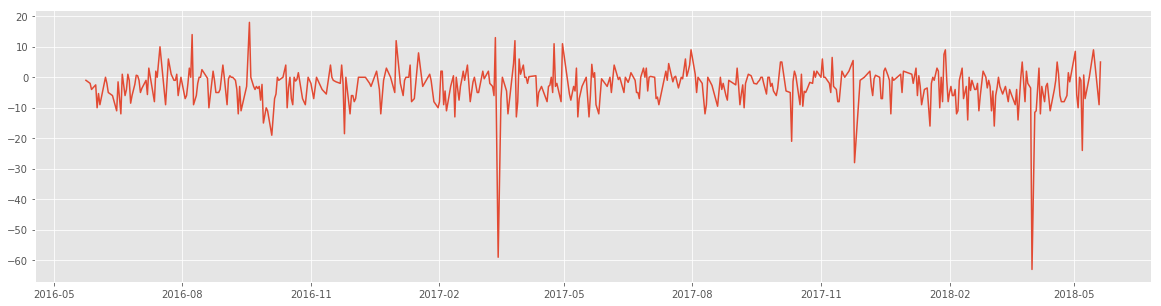

In [135]:
# Plot for Watson Sentiment and Polarity
plt.figure(figsize=(20,5))
plt.plot(Nestle_NZZ_other_df['date'],Nestle_NZZ_other_df['sentiment'])
plt.show()

## Analysis of Novartis

### Loading Articles of past 2 years

In [136]:
a_list = []
for n in range(1,18):    
    sauce = open('Novartis_NZZ_Full'+str(n)+'.htm','rb')
    soup = BeautifulSoup(sauce,'html.parser')
    content = soup.find_all('div',{'class':'singleDocument modulePageBreak'})
    #count=1
    for i in content:
        #print(count)
        time = i.find_all('pre',{'class':'gray'})[0].text
        #title = i.find_all('pre',{'class':'boldLarge'})[0].text
        text = i.find_all('pre',{'class':'text'})[0].text
        teatime = ''
        for j in time:
            if j.isdigit() == True or j == '.':
                teatime += j
        time = teatime[:10]
        #count+=1
        
        a_list.append([time,text])


In [137]:
Novartis_NZZ_df = pd.DataFrame(a_list,columns=['date','text'])
Novartis_NZZ_df.head()

,date,text
0,20.05.2018,Arztvisite in Kolumbien: Auch hier hat sich di...
1,20.05.2018,Novartis und Roche haben gemäss Register 2005 ...
2,20.05.2018,Hat bei Sterbenskranken jede andere Therapie v...
3,20.05.2018,Kleine und mittlere global tätige Unternehmen ...
4,20.05.2018,Franziska Pfister\n\nJoe Jimenez ist an einem ...


## Sentiment Analysis with Textblob

In [138]:
# The x in the lambda function is a row (because I set axis=1)
# Apply iterates the function accross the dataframe's rows
Novartis_NZZ_df['polarity'] = Novartis_NZZ_df.apply(lambda x: TextBlob(x['text']).sentiment.polarity, axis=1)
Novartis_NZZ_df['subjectivity'] = Novartis_NZZ_df.apply(lambda x: TextBlob(x['text']).sentiment.subjectivity, axis=1)

In [139]:
# Create .dt.date format
Novartis_NZZ_df['datetime'] = pd.to_datetime(Novartis_NZZ_df['date'],format='%d.%m.%Y')
Novartis_NZZ_df.at[0,'datetime']
Novartis_NZZ_df.head()

,date,text,polarity,subjectivity,datetime
0,20.05.2018,Arztvisite in Kolumbien: Auch hier hat sich di...,0.000000,0.000000,2018-05-20
1,20.05.2018,Novartis und Roche haben gemäss Register 2005 ...,0.000000,0.000000,2018-05-20
2,20.05.2018,Hat bei Sterbenskranken jede andere Therapie v...,-0.025000,0.266667,2018-05-20
3,20.05.2018,Kleine und mittlere global tätige Unternehmen ...,-0.066667,0.346667,2018-05-20
4,20.05.2018,Franziska Pfister\n\nJoe Jimenez ist an einem ...,0.068182,0.393939,2018-05-20


In [140]:
# Creates a function that computes the mean value for each day 
unique_dates = Novartis_NZZ_df['date'].unique()

Novartis_NZZ_New_df = pd.DataFrame()

for date in unique_dates:
    
    same_date = Novartis_NZZ_df.loc[Novartis_NZZ_df['date'] == date]
    polarity_mean = same_date['polarity'].mean()
    subjectivity_mean = same_date['subjectivity'].mean()
    Novartis_NZZ_New_df = Novartis_NZZ_New_df.append({'date': date,'polarity': polarity_mean, 
                                          'subjectivity': subjectivity_mean}, ignore_index=True)


In [141]:
Novartis_NZZ_New_df['date']=pd.to_datetime(Novartis_NZZ_New_df['date'],format='%d.%m.%Y')
Novartis_NZZ_New_df.sort_values(by='date').head()

,date,polarity,subjectivity
504,2016-05-22,0.150000,0.500000
503,2016-05-23,0.000000,0.000000
502,2016-05-24,0.113636,0.272727
501,2016-05-25,-0.050000,0.100000
500,2016-05-26,0.000000,0.100000


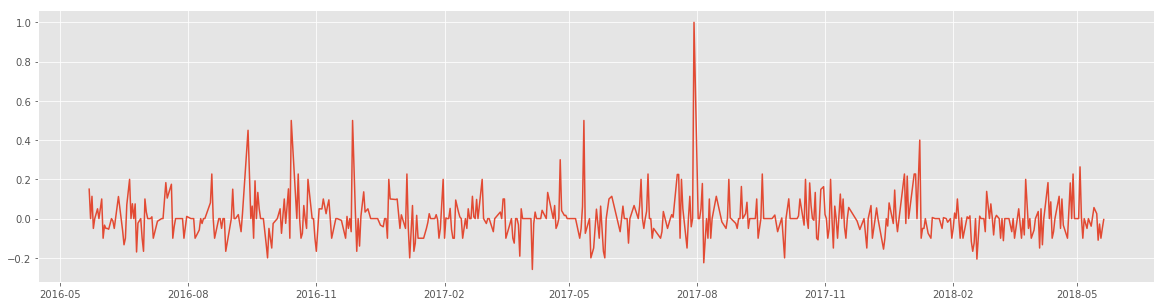

In [142]:
# Plot for Watson Sentiment and Polarity
plt.figure(figsize=(20,5))
plt.plot(Novartis_NZZ_New_df['date'],Novartis_NZZ_New_df['polarity'])
#plt.plot(Novartis_NZZ_New_df['date'],Novartis_NZZ_New_df['subjectivity'])
plt.show()

## Sentiment Analysis with SentiWS Dictionary

In [143]:
# Tokenize and stop words removal
def tokenize(text):

    # Convert to lower case
    words = map(lambda word: word.lower(), word_tokenize(text))
    
    # Remove stop words
    cachedStopWords = stopwords.words("german")
    words = [word for word in words
                  if word not in cachedStopWords]
    
    # Steam the words
    tokens =(list(map(lambda token: PorterStemmer().stem(token), words)))
    
    # Remove non-letters 
    p = re.compile('[a-zA-Z]+')
    
    # Remove less than 3 length words
    min_length = 3
    filtered_tokens = list(filter(lambda token: p.match(token) and len(token) >= min_length, tokens))
    
    return filtered_tokens

In [144]:
# Apply tokenizer to UBS
Novartis_NZZ_df['tokens'] = Novartis_NZZ_df['text'].apply(tokenize)

In [145]:
Novartis_NZZ_df['tokens'][0]

['arztvisit',
 'kolumbien',
 'anzahl',
 'versuch',
 'novarti',
 'roch',
 'durchführen',
 'letzten']

In [146]:
with open('Bannier_Positive.csv', 'r') as f: 
    pos = ''
    for row in f:
        pos += row.replace('\n',',')
with open('Bannier_Negative.csv', 'r') as f: 
    neg = ''
    for row in f:
        neg += row.replace('\n',',')

In [147]:
def text_mine_articles(Novartis_NZZ_df, bag_of_words,alignment):
    
    bag_of_words = tokenize(bag_of_words)
    Novartis_NZZ_df['num_occurr_'+alignment] = 0
    
    # 'Set' to make the counting operation faster
    set_of_words = set(bag_of_words)
    
    print('Text mine articles...'),
    
    for j in range(0, len(Novartis_NZZ_df)):
        
        # Convert article body into a list of tokens
        tokenized_article = tokenize(Novartis_NZZ_df['text'][j])
        
        # Count occurrences of the dictionary of words
        occurrences = [word for word in tokenized_article
                        if word in set_of_words]
        
        # Copy amount of occurrences found to the dataframe
        amount = len(occurrences)
        Novartis_NZZ_df['num_occurr_'+alignment][j] = amount
        
    # Compute frequency of occurrence found in each article dividing
    # the amount of words counted as occurrences by the amount of words in the article
    # UBS_df['freq_occurr_'+alignment] = UBS_df['num_occurr_'+alignment]/UBS_df['word_count']   
   
    print('Done!')
 
    return Novartis_NZZ_df

In [148]:
Novartis_NZZ_df = text_mine_articles(Novartis_NZZ_df, pos,'pos')
Novartis_NZZ_df = text_mine_articles(Novartis_NZZ_df, neg,'neg')

Text mine articles...


/Users/Jannick/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Done!
Text mine articles...
Done!


In [149]:
## Sentiment Score Roche
# The following function provides a simple function to create a sentiment score
Novartis_NZZ_df['sentiment_score'] = Novartis_NZZ_df['num_occurr_pos'] - Novartis_NZZ_df['num_occurr_neg']

In [150]:
# Create .dt.date format
Novartis_NZZ_df['datetime'] = pd.to_datetime(Novartis_NZZ_df['date'],format='%d.%m.%Y')
Novartis_NZZ_df.at[0,'datetime']
Novartis_NZZ_df

,date,text,polarity,subjectivity,datetime,tokens,num_occurr_pos,num_occurr_neg,sentiment_score
0,20.05.2018,Arztvisite in Kolumbien: Auch hier hat sich di...,0.000000,0.000000,2018-05-20,"[arztvisit, kolumbien, anzahl, versuch, novart...",0,0,0
1,20.05.2018,Novartis und Roche haben gemäss Register 2005 ...,0.000000,0.000000,2018-05-20,"[novarti, roch, gemäss, regist, erst, studien,...",0,0,0
2,20.05.2018,Hat bei Sterbenskranken jede andere Therapie v...,-0.025000,0.266667,2018-05-20,"[sterbenskranken, therapi, versagt, letzter, h...",16,22,-6
3,20.05.2018,Kleine und mittlere global tätige Unternehmen ...,-0.066667,0.346667,2018-05-20,"[klein, mittler, global, tätige, unternehmen, ...",15,10,5
4,20.05.2018,Franziska Pfister\n\nJoe Jimenez ist an einem ...,0.068182,0.393939,2018-05-20,"[franziska, pfister, joe, jimenez, wintertag, ...",9,19,-10
5,19.05.2018,(awp) · Der Schweizer Aktienmarkt hat am Freit...,-0.100000,0.225000,2018-05-19,"[awp, schweizer, aktienmarkt, freitag, pfingst...",5,14,-9
6,19.05.2018,(awp) · Novartis darf sein Migränemedikament A...,0.000000,0.000000,2018-05-19,"[awp, novarti, darf, migränemedika, aimovig, u...",0,1,-1
7,18.05.2018,(awp) · Der Schweizer Aktienmarkt hat am Donne...,-0.100000,0.350000,2018-05-18,"[awp, schweizer, aktienmarkt, donnerstag, leic...",5,12,-7
8,17.05.2018,Novartis-Zahlung an Michael Cohen,0.000000,0.000000,2018-05-17,"[novartis-zahlung, michael, cohen]",0,0,0
9,17.05.2018,(awp) · Der Schweizer Aktienmarkt hat am Mittw...,-0.150000,0.350000,2018-05-17,"[awp, schweizer, aktienmarkt, mittwoch, leicht...",4,10,-6


In [151]:
# Creates a function that computes the mean value for each day 
unique_dates = Novartis_NZZ_df['date'].unique()

Novartis_NZZ_other_df = pd.DataFrame()

for date in unique_dates:
    
    same_date = Novartis_NZZ_df.loc[Novartis_NZZ_df['date'] == date]
    sentiment_mean = same_date['sentiment_score'].mean()
    Novartis_NZZ_other_df = Novartis_NZZ_other_df.append({'date': date,'sentiment': sentiment_mean}, ignore_index=True)


In [152]:
Novartis_NZZ_other_df['date']=pd.to_datetime(Novartis_NZZ_other_df['date'],format='%d.%m.%Y')
Novartis_NZZ_other_df.sort_values(by='date').head()

,date,sentiment
504,2016-05-22,-2.0
503,2016-05-23,0.0
502,2016-05-24,-0.5
501,2016-05-25,-1.5
500,2016-05-26,-3.0


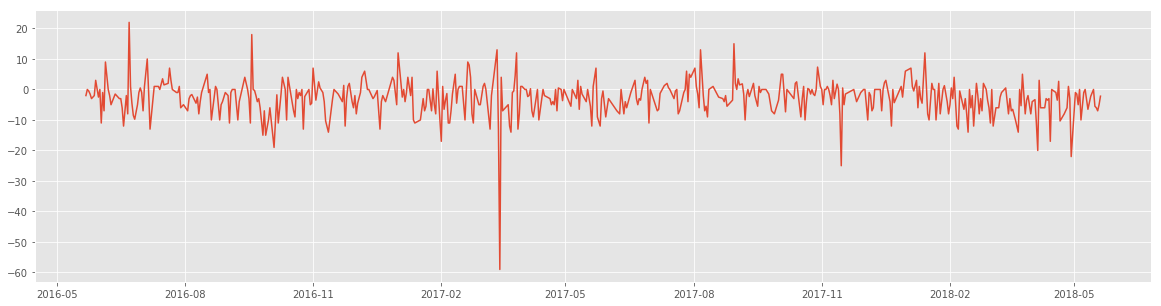

In [153]:
# Plot for Watson Sentiment and Polarity
plt.figure(figsize=(20,5))
plt.plot(Novartis_NZZ_other_df['date'],Novartis_NZZ_other_df['sentiment'])
plt.show()

## Analysis of Roche

In [156]:
a_list = []
for n in range(1,18):    
    sauce = open('Roche_NZZ_Full'+str(n)+'.htm','rb')
    soup = BeautifulSoup(sauce,'html.parser')
    content = soup.find_all('div',{'class':'singleDocument modulePageBreak'})
    #count=1
    for i in content:
        #print(count)
        time = i.find_all('pre',{'class':'gray'})[0].text
        #title = i.find_all('pre',{'class':'boldLarge'})[0].text
        text = i.find_all('pre',{'class':'text'})[0].text
        teatime = ''
        for j in time:
            if j.isdigit() == True or j == '.':
                teatime += j
        time = teatime[:10]
        #count+=1
        
        a_list.append([time,text])


In [157]:
Roche_NZZ_df = pd.DataFrame(a_list,columns=['date','text'])
Roche_NZZ_df.head()

,date,text
0,20.05.2018,Arztvisite in Kolumbien: Auch hier hat sich di...
1,20.05.2018,Novartis und Roche haben gemäss Register 2005 ...
2,20.05.2018,Hat bei Sterbenskranken jede andere Therapie v...
3,19.05.2018,AstraZeneca unter Druck der Anleger
4,19.05.2018,(awp) · Der Schweizer Aktienmarkt hat am Freit...


## Sentiment Analysis with Textblob

In [158]:
# The x in the lambda function is a row (because I set axis=1)
# Apply iterates the function accross the dataframe's rows
Roche_NZZ_df['polarity'] = Roche_NZZ_df.apply(lambda x: TextBlob(x['text']).sentiment.polarity, axis=1)
Roche_NZZ_df['subjectivity'] = Roche_NZZ_df.apply(lambda x: TextBlob(x['text']).sentiment.subjectivity, axis=1)

In [159]:
# Create .dt.date format
Roche_NZZ_df['datetime'] = pd.to_datetime(Roche_NZZ_df['date'],format='%d.%m.%Y')
Roche_NZZ_df.at[0,'datetime']
Roche_NZZ_df.head()

,date,text,polarity,subjectivity,datetime
0,20.05.2018,Arztvisite in Kolumbien: Auch hier hat sich di...,0.000,0.000000,2018-05-20
1,20.05.2018,Novartis und Roche haben gemäss Register 2005 ...,0.000,0.000000,2018-05-20
2,20.05.2018,Hat bei Sterbenskranken jede andere Therapie v...,-0.025,0.266667,2018-05-20
3,19.05.2018,AstraZeneca unter Druck der Anleger,0.000,0.000000,2018-05-19
4,19.05.2018,(awp) · Der Schweizer Aktienmarkt hat am Freit...,-0.100,0.225000,2018-05-19


In [160]:
# Creates a function that computes the mean value for each day 
unique_dates = Roche_NZZ_df['date'].unique()

Roche_NZZ_New_df = pd.DataFrame()

for date in unique_dates:
    
    same_date = Roche_NZZ_df.loc[Roche_NZZ_df['date'] == date]
    polarity_mean = same_date['polarity'].mean()
    subjectivity_mean = same_date['subjectivity'].mean()
    Roche_NZZ_New_df = Roche_NZZ_New_df.append({'date': date,'polarity': polarity_mean, 
                                          'subjectivity': subjectivity_mean}, ignore_index=True)


In [161]:
Roche_NZZ_New_df['date']=pd.to_datetime(Roche_NZZ_New_df['date'],format='%d.%m.%Y')
Roche_NZZ_New_df.sort_values(by='date').head()

,date,polarity,subjectivity
496,2016-05-23,0.000000,0.000000
495,2016-05-24,0.227273,0.545455
494,2016-05-25,-0.050000,0.266667
493,2016-05-26,0.000000,0.100000
492,2016-05-28,0.033333,0.116667


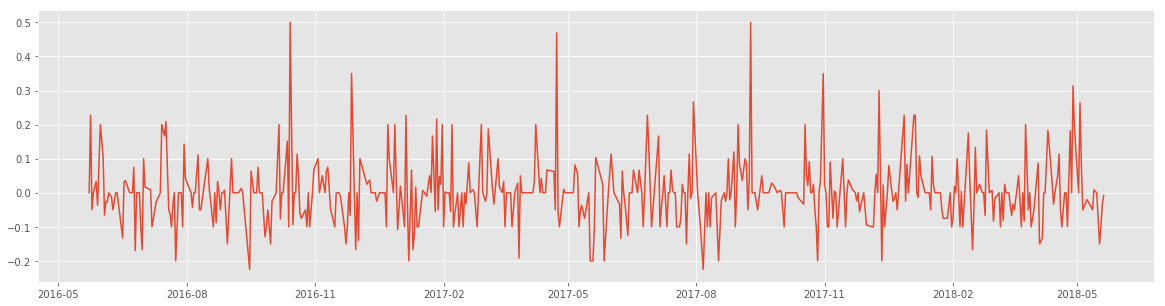

In [162]:
# Plot for Watson Sentiment and Polarity
plt.figure(figsize=(20,5))
plt.plot(Roche_NZZ_New_df['date'],Roche_NZZ_New_df['polarity'])
#plt.plot(Roche_NZZ_New_df['date'],Roche_NZZ_New_df['subjectivity'])
plt.show()

## Sentiment Analysis with SentiWS Dictionary

In [163]:
# Tokenize and stop words removal
def tokenize(text):

    # Convert to lower case
    words = map(lambda word: word.lower(), word_tokenize(text))
    
    # Remove stop words
    cachedStopWords = stopwords.words("german")
    words = [word for word in words
                  if word not in cachedStopWords]
    
    # Steam the words
    tokens =(list(map(lambda token: PorterStemmer().stem(token), words)))
    
    # Remove non-letters 
    p = re.compile('[a-zA-Z]+')
    
    # Remove less than 3 length words
    min_length = 3
    filtered_tokens = list(filter(lambda token: p.match(token) and len(token) >= min_length, tokens))
    
    return filtered_tokens

In [164]:
# Apply tokenizer to UBS
Roche_NZZ_df['tokens'] = Roche_NZZ_df['text'].apply(tokenize)

In [165]:
Roche_NZZ_df['tokens'][0]

['arztvisit',
 'kolumbien',
 'anzahl',
 'versuch',
 'novarti',
 'roch',
 'durchführen',
 'letzten']

In [166]:
with open('Bannier_Positive.csv', 'r') as f: 
    pos = ''
    for row in f:
        pos += row.replace('\n',',')
with open('Bannier_Negative.csv', 'r') as f: 
    neg = ''
    for row in f:
        neg += row.replace('\n',',')

In [167]:
def text_mine_articles(Roche_NZZ_df, bag_of_words,alignment):
    
    bag_of_words = tokenize(bag_of_words)
    Roche_NZZ_df['num_occurr_'+alignment] = 0
    
    # 'Set' to make the counting operation faster
    set_of_words = set(bag_of_words)
    
    print('Text mine articles...'),
    
    for j in range(0, len(Roche_NZZ_df)):
        
        # Convert article body into a list of tokens
        tokenized_article = tokenize(Roche_NZZ_df['text'][j])
        
        # Count occurrences of the dictionary of words
        occurrences = [word for word in tokenized_article
                        if word in set_of_words]
        
        # Copy amount of occurrences found to the dataframe
        amount = len(occurrences)
        Roche_NZZ_df['num_occurr_'+alignment][j] = amount
        
    # Compute frequency of occurrence found in each article dividing
    # the amount of words counted as occurrences by the amount of words in the article
    # UBS_df['freq_occurr_'+alignment] = UBS_df['num_occurr_'+alignment]/UBS_df['word_count']   
   
    print('Done!')
 
    return Roche_NZZ_df

In [168]:
Roche_NZZ_df = text_mine_articles(Roche_NZZ_df, pos,'pos')
Roche_NZZ_df = text_mine_articles(Roche_NZZ_df, neg,'neg')

Text mine articles...


/Users/Jannick/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Done!
Text mine articles...
Done!


In [169]:
## Sentiment Score Roche
# The following function provides a simple function to create a sentiment score
Roche_NZZ_df['sentiment_score'] = Roche_NZZ_df['num_occurr_pos'] - Roche_NZZ_df['num_occurr_neg']

In [170]:
# Create .dt.date format
Roche_NZZ_df['datetime'] = pd.to_datetime(Roche_NZZ_df['date'],format='%d.%m.%Y')
Roche_NZZ_df.at[0,'datetime']
Roche_NZZ_df

,date,text,polarity,subjectivity,datetime,tokens,num_occurr_pos,num_occurr_neg,sentiment_score
0,20.05.2018,Arztvisite in Kolumbien: Auch hier hat sich di...,0.000000,0.000000,2018-05-20,"[arztvisit, kolumbien, anzahl, versuch, novart...",0,0,0
1,20.05.2018,Novartis und Roche haben gemäss Register 2005 ...,0.000000,0.000000,2018-05-20,"[novarti, roch, gemäss, regist, erst, studien,...",0,0,0
2,20.05.2018,Hat bei Sterbenskranken jede andere Therapie v...,-0.025000,0.266667,2018-05-20,"[sterbenskranken, therapi, versagt, letzter, h...",16,22,-6
3,19.05.2018,AstraZeneca unter Druck der Anleger,0.000000,0.000000,2018-05-19,"[astrazeneca, druck, anleg]",0,1,-1
4,19.05.2018,(awp) · Der Schweizer Aktienmarkt hat am Freit...,-0.100000,0.225000,2018-05-19,"[awp, schweizer, aktienmarkt, freitag, pfingst...",5,14,-9
5,19.05.2018,Der schweizerische Aktienmarkt,0.000000,0.000000,2018-05-19,"[schweizerisch, aktienmarkt]",0,0,0
6,18.05.2018,(awp) · Der Schweizer Aktienmarkt hat am Donne...,-0.100000,0.350000,2018-05-18,"[awp, schweizer, aktienmarkt, donnerstag, leic...",5,12,-7
7,17.05.2018,(awp) · Der Schweizer Aktienmarkt hat am Mittw...,-0.150000,0.350000,2018-05-17,"[awp, schweizer, aktienmarkt, mittwoch, leicht...",4,10,-6
8,15.05.2018,(awp) · Der Schweizer Aktienmarkt ist am Monta...,0.000000,0.433333,2018-05-15,"[awp, schweizer, aktienmarkt, montag, kaum, ve...",3,5,-2
9,13.05.2018,"Wenn es harzt, dann harzt es. Eigentlich war d...",-0.200000,0.600000,2018-05-13,"[harzt, harzt, eigentlich, meldung, pharmaries...",3,4,-1


In [171]:
# Creates a function that computes the mean value for each day 
unique_dates = Roche_NZZ_df['date'].unique()

Roche_NZZ_other_df = pd.DataFrame()

for date in unique_dates:
    
    same_date = Roche_NZZ_df.loc[Roche_NZZ_df['date'] == date]
    sentiment_mean = same_date['sentiment_score'].mean()
    Roche_NZZ_other_df = Roche_NZZ_other_df.append({'date': date,'sentiment': sentiment_mean}, ignore_index=True)


In [172]:
Roche_NZZ_other_df['date']=pd.to_datetime(Roche_NZZ_other_df['date'],format='%d.%m.%Y')
Roche_NZZ_other_df.sort_values(by='date').head()

,date,sentiment
496,2016-05-23,0.0
495,2016-05-24,-1.0
494,2016-05-25,1.0
493,2016-05-26,-3.0
492,2016-05-28,-2.0


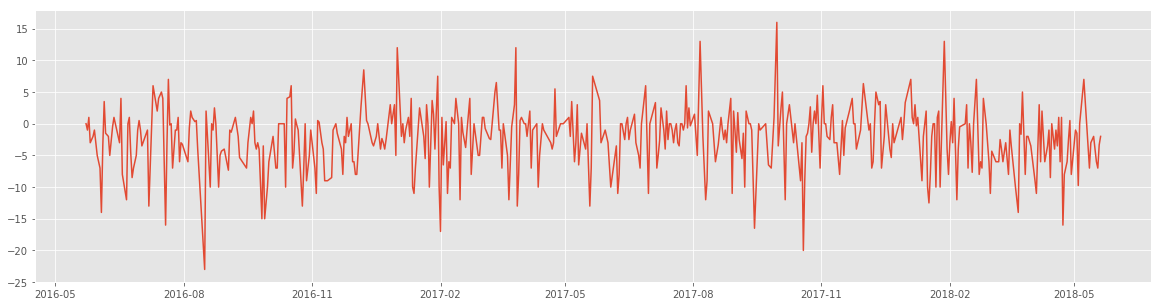

In [173]:
# Plot for Watson Sentiment and Polarity
plt.figure(figsize=(20,5))
plt.plot(Roche_NZZ_other_df['date'],Roche_NZZ_other_df['sentiment'])
plt.show()